# <font color=#214B99>Projet 7 - Détectez les Bad Buzz grâce au Deep Learning</font>

# <font color=#009BFA>Approche 3 : Modèle sur mesure avancé</font>


## Objectif du projet : 
- **Développer le prototype d’un produit IA permettant de prédire le sentiment associé à un tweet**

## Trois approches :
- **Approche 1 : 'API sur étagère' en utilisant l’API du service cognitif proposé par Microsoft Azure pour l’analyse de sentiment**
- **Approche 2 : 'Modèle sur mesure simple' en utilisant le service Azure Machine Learning Studio**
- **Approche 3 : 'Modèle sur mesure avancé' en utilisant le service Azure Machine Learning pour développer un modèle basé sur des réseaux de neurones profonds pour prédire le sentiment associé à un tweet**.


## <font color="#009BFA">Sommaire</font>
1. [**Préparation des données**](#section_1)
    - Chargement des données
    - Nettoyage des données
    - Identification de la cible
    - Séparation du jeu de données <br><br>
2. [**Prétraitement des données textuelles (PreProcessing)**](#section_2)
    - Essai de deux techniques de prétraitement
        - Nettoyage des Tweets avec la librairie 'Preprocessor'
        - Lemmatization des Tweets avec la librairie 'SpaCy'
    - Prétraitement des différents DataFrame <br><br>
3. [**Approche Machine Learning classique (modèle de référence)**](#section_3)
    - Choix de la métrique d'évaluation
    - Représentation des données textuelles : TFIDF
    - Modélisation : Regression logistique
    - Evaluation <br><br>
4. [**Approche Deep Learning (modèles avancés)**](#section_4)
    - Représentation des données textuelles : plongements de mots (Words Embeddings)
        - Modèles GloVe classique préentrainé
        - Modèle préentrainé sur des Tweets : GloVe Twitter
    - Modélisation : Réseaux de neurones
        - Création des jeux de données adaptés aux modèles réseaux de neurones
        - Modélisations utilisant différentes architectures
        - Evaluation
        - Sélection du meilleur modèle
        - Optimisation du meilleur modèle
            - Optimisation du plongement de mots
                - Modèle FastText entrainé sur les Tweets du jeu d'entrainement
            - Optimisation des hyperparamètres
                - Optimisation des Dropout
                - Optimisation du Learning Rate
            - Choix du meilleur nombre d'epochs
        - Evaluation du meilleur modèle optimisé
        - Sauvegarde du meilleur modèle
        - Prédictions sur le jeu de données 'app' pour comparaison avec les autres approches <br><br>
5. [**Prototype permettant de prédire le sentiment associé à un tweet**](#section_5) 
    - Fonction 'prototype'
    - Test du modèle en local

In [1]:
import io

from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

import gensim.downloader as api

import spacy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    SpatialDropout1D,
    Input,
    Conv1D,
    GlobalMaxPooling1D,
)
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, SimpleRNN
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from keras_preprocessing.text import tokenizer_from_json

from gensim.models import FastText

import preprocessor as tweetpreprocessor

import time
import random as python_random

# Valide code pep8
%load_ext nb_black
from datetime import datetime

now = datetime.now().isoformat()
print("Lancé le           : " + now)

import warnings

warnings.filterwarnings("ignore")

Lancé le           : 2022-06-30T21:06:04.807302


<IPython.core.display.Javascript object>

In [2]:
nlp = spacy.load("en_core_web_sm")

<IPython.core.display.Javascript object>

In [3]:
import os

os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices"

<IPython.core.display.Javascript object>

##### On fixe l'aléatoire pour la reproductibilité des modélisations :

In [4]:
SEED = 0
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

<IPython.core.display.Javascript object>

 # <span style='color:blue' id="section_1" >1. Préparation des données</span>

>## <span style='color:green' id="section_1_1" >1.1. Chargement des données</span>

In [5]:
path_dataset = "airparadis_dataset/"

<IPython.core.display.Javascript object>

In [6]:
data = pd.read_csv(
    path_dataset + "training.1600000.processed.noemoticon.csv",
    nrows=1000000,
    encoding="ISO-8859-1",
    header=None,
)

<IPython.core.display.Javascript object>

In [7]:
data.shape

(1000000, 6)

<IPython.core.display.Javascript object>

In [8]:
data

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
999995,4,1879942807,Thu May 21 23:36:19 PDT 2009,NO_QUERY,divabat,"@healingsinger thank you, i needed that"
999996,4,1879942922,Thu May 21 23:36:20 PDT 2009,NO_QUERY,nick1975,@vactress http://bit.ly/cADea Maybe this is m...
999997,4,1879942975,Thu May 21 23:36:21 PDT 2009,NO_QUERY,znmeb,"@Brat13 Hell, Windows 7 will be out of my pric..."
999998,4,1879943113,Thu May 21 23:36:22 PDT 2009,NO_QUERY,virmani,@jigardoshi neah.. i wish! just reminiscing r...


<IPython.core.display.Javascript object>

>## <span style='color:green' id="section_1_2" >1.2. Nettoyage des données</span>

- Nous gardons uniquement les colonnes 0 et 5 qui nous seront utiles pour notre étude
- Nous renommons les colonnes 'SENTIMENT' et 'TWEET'

In [9]:
df_tweets_total = pd.concat([data[0], data[5]], axis=1)

<IPython.core.display.Javascript object>

In [10]:
df_tweets_total = df_tweets_total.rename(columns={0: "SENTIMENT", 5: "TWEET"})

<IPython.core.display.Javascript object>

In [11]:
df_tweets_total

,SENTIMENT,TWEET
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
999995,4,"@healingsinger thank you, i needed that"
999996,4,@vactress http://bit.ly/cADea Maybe this is m...
999997,4,"@Brat13 Hell, Windows 7 will be out of my pric..."
999998,4,@jigardoshi neah.. i wish! just reminiscing r...


<IPython.core.display.Javascript object>

In [12]:
df_tweets = df_tweets_total.groupby("SENTIMENT").apply(lambda x: x.sample(70000))

<IPython.core.display.Javascript object>

In [13]:
df_tweets["SENTIMENT"].value_counts()

0    70000
4    70000
Name: SENTIMENT, dtype: int64

<IPython.core.display.Javascript object>

##### Ce jeu de données contient :
- Les Tweets (colonne 'TWEET')
- Le sentiment associé à chaque Tweet (colonne 'SENTIMENT')

>## <span style='color:green' id="section_1_3" >1.3. Identification de la cible</span>

- La cible correspond à la colonne 'SENTIMENT'
- Il y a 2 valeurs possibles : 0 et 4
    - La valeur 0 correspond à un sentiment négatif
    - La valeur 4 correspond à un sentiment positif
- Pour plus de cohérence, nous allons remplacer la valeur 4 par 1
- Les Tweets sont équirépartis par sentiment

In [14]:
df_tweets["SENTIMENT"].value_counts()

0    70000
4    70000
Name: SENTIMENT, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
df_tweets["SENTIMENT"] = df_tweets["SENTIMENT"].replace(4, 1)

<IPython.core.display.Javascript object>

In [16]:
df_tweets

SENTIMENT                                              TWEET
SENTIMENT                                                                     
0         158171          0  oh god whits pissed n shes drivin, in the rain...
          480078          0                    driving back from myrtle beach 
          258275          0  Saying byebye to AM's Refuge and Extension  wi...
          20237           0  @SarahSaner Did you she fell of her horse agai...
          354111          0                        @SalioElSol08  save me any.
...                     ...                                                ...
4         868144          1  @ThatKevinSmith love the twitter pg background...
          989183          1  @JenniferJ13 OMG you were what?! thats sooo co...
          853695          1  : Maybe they'll pump other sorts of alkie inst...
          879628          1  @IfUuseitUcanfly and BTW James is on here now....
          830402          1  @anikainlondon yay! spotify!  i'm listening to...

[140000 rows x 2 columns]

<IPython.core.display.Javascript object>

In [17]:
df_tweets["SENTIMENT"].value_counts()

0    70000
1    70000
Name: SENTIMENT, dtype: int64

<IPython.core.display.Javascript object>

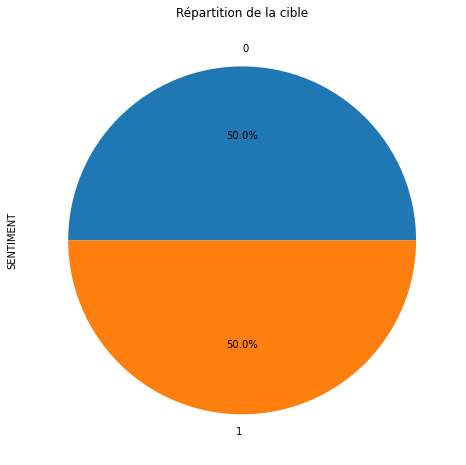

<IPython.core.display.Javascript object>

In [18]:
_ = (
    df_tweets["SENTIMENT"]
    .value_counts()
    .plot(
        kind="pie", figsize=(10, 8), autopct="%1.1f%%", title="Répartition de la cible"
    )
)

>## <span style='color:green' id="section_1_4" >1.4. Séparation du jeu de données</span>

### Création des jeux de données suivants :

- 'Approach' (app) : utilisé pour comparer les trois approches et sélectionner la meilleure parmi les trois (API sur étagère, modèle simple, modèle avancé)
- 'Validation' (val) : utilisé pour la sélection du meilleur modèle avancé et l'optimisation des hyperparamètres
- 'Train' (train) : utilisé pour entrainer le meilleur modèle et obtenir le modèle qui sera déployé
- 'Train_sample (train_sample)' : échantillon extrait du jeu 'Train' pour entrainer les différents modèles avancés
- 'Test' (test) : utilisé pour l'évaluation finale du meilleur modèle avancé

#### Remarques :
- Les jeux de données sont stratifiés afin de garder la proportion de sentiments positifs et négatifs
- Nous avons été particulièrement attentifs à ne pas toucher le jeu de test afin qu'il n'y ait pas de fuite de données

>## <span style='color:#1e488f' >Création du DataFrame `Approach`</span>

In [19]:
APP_SIZE = 2000

<IPython.core.display.Javascript object>

In [20]:
df_app, df_tweets = train_test_split(
    df_tweets, stratify=df_tweets["SENTIMENT"], train_size=APP_SIZE, random_state=SEED
)

<IPython.core.display.Javascript object>

In [21]:
df_tweets

SENTIMENT                                              TWEET
SENTIMENT                                                                     
4         877703          1  @JoshRamsay I just noticed you look like Justi...
          987313          1  @sidv hahaha!! ur a riot! Pak and wipe out the...
          998057          1  me first poppies flowering  http://www.fab-des...
          860512          1  @ttakeiteasy It is a great show. You are sooo ...
          900547          1  @trinemt I'm excited! Hust let me know when yo...
...                     ...                                                ...
0         209422          0  @rachmurrayX why dont i have that music channe...
4         939339          1  @LaGraphixGirl your day has just begun huh   Y...
0         236641          0  chilling...hmm...listening to music...download...
          659661          0  My skin doctor said I have to remove my moles ...
4         819270          1  Painted me nails. My fav color. It looks natur...

[138000 rows x 2 columns]

<IPython.core.display.Javascript object>

In [22]:
df_tweets = df_tweets.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [23]:
df_tweets

,SENTIMENT,TWEET
0,1,@JoshRamsay I just noticed you look like Justi...
1,1,@sidv hahaha!! ur a riot! Pak and wipe out the...
2,1,me first poppies flowering http://www.fab-des...
3,1,@ttakeiteasy It is a great show. You are sooo ...
4,1,@trinemt I'm excited! Hust let me know when yo...
...,...,...
137995,0,@rachmurrayX why dont i have that music channe...
137996,1,@LaGraphixGirl your day has just begun huh Y...
137997,0,chilling...hmm...listening to music...download...
137998,0,My skin doctor said I have to remove my moles ...


<IPython.core.display.Javascript object>

In [24]:
df_tweets["SENTIMENT"].value_counts()

1    69000
0    69000
Name: SENTIMENT, dtype: int64

<IPython.core.display.Javascript object>

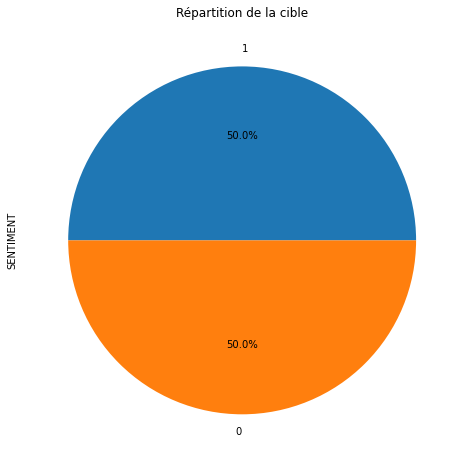

<IPython.core.display.Javascript object>

In [25]:
_ = (
    df_tweets["SENTIMENT"]
    .value_counts()
    .plot(
        kind="pie", figsize=(10, 8), autopct="%1.1f%%", title="Répartition de la cible"
    )
)

In [26]:
df_app = df_app.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [27]:
df_app

,SENTIMENT,TWEET
0,1,@seanlb Got them all
1,0,On my way in to the office...raining
2,0,going to my cousin's funeral
3,1,@ShannonRenee
4,0,Downloading the final iPhone 3.0 SDK from Appl...
...,...,...
1995,1,haha I know all the conversations and I could ...
1996,0,"Missing my phone, which is at the bottom of th..."
1997,0,Please noooo...Dave Gahan has cancer scare
1998,0,"@ravenme in NYC, you don't have to shoot yours..."


<IPython.core.display.Javascript object>

#### Taille du jeu 'Approach'

In [28]:
len(df_app["SENTIMENT"])

2000

<IPython.core.display.Javascript object>

#### Répartition du jeu 'Approach'

In [29]:
df_app["SENTIMENT"].value_counts()

1    1000
0    1000
Name: SENTIMENT, dtype: int64

<IPython.core.display.Javascript object>

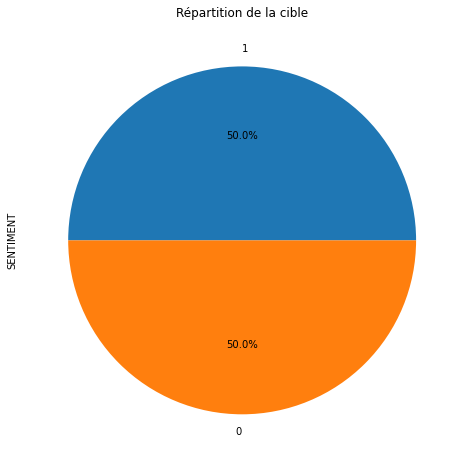

<IPython.core.display.Javascript object>

In [30]:
_ = (
    df_app["SENTIMENT"]
    .value_counts()
    .plot(
        kind="pie", figsize=(10, 8), autopct="%1.1f%%", title="Répartition de la cible"
    )
)

>## <span style='color:#1e488f' >Création du DataFrame `Validation`</span>

In [31]:
VAL_SIZE = 35000

<IPython.core.display.Javascript object>

In [32]:
df_val, df_tweets = train_test_split(
    df_tweets, stratify=df_tweets["SENTIMENT"], train_size=VAL_SIZE, random_state=SEED
)

<IPython.core.display.Javascript object>

In [33]:
df_tweets = df_tweets.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [34]:
df_tweets

,SENTIMENT,TWEET
0,1,"@bethanie Yay! So, you're all visible again?"
1,0,Wishing night time wasn't the time when i thin...
2,1,What could be better than top ramen at 11 at n...
3,0,i am getting such sore stomach cramps atm.. x
4,1,Has got to go to work with a slight hangover g...
...,...,...
102995,1,Good Morning/Good Afternoon or Good Evening de...
102996,1,"so tired, but not at the same time - not wanti..."
102997,0,@MissFarrari I lost!!! Whomp whomp whomp
102998,0,ARG!! IT'S 81 DEGREES! Why must it be so hot? ...


<IPython.core.display.Javascript object>

In [35]:
df_tweets["SENTIMENT"].value_counts()

1    51500
0    51500
Name: SENTIMENT, dtype: int64

<IPython.core.display.Javascript object>

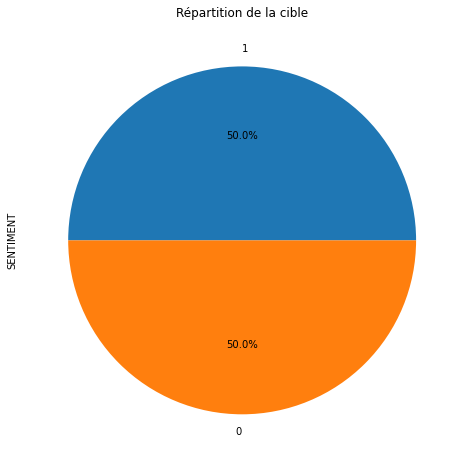

<IPython.core.display.Javascript object>

In [36]:
_ = (
    df_tweets["SENTIMENT"]
    .value_counts()
    .plot(
        kind="pie", figsize=(10, 8), autopct="%1.1f%%", title="Répartition de la cible"
    )
)

In [37]:
df_val = df_val.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [38]:
df_val

,SENTIMENT,TWEET
0,1,@OsmentEmily hey how are you?
1,0,@KimBlairwitch - Not possible whilst live on t...
2,1,@NSpirit You have such a baby face!
3,0,@zanyalves eu tb
4,0,@aliceirene I do!! I'm not in yo citaaay thou...
...,...,...
34995,1,@dbldbl no not yet...
34996,1,@kyleandjackieo yea rove is on
34997,1,InTheSpotlight with adri&amp;kent yeee!
34998,1,@mileycyrus Miley! Please tell everyone to bu...


<IPython.core.display.Javascript object>

#### Taille du jeu 'Validation'

In [39]:
len(df_val["SENTIMENT"])

35000

<IPython.core.display.Javascript object>

#### Répartition du jeu 'Validation'

In [40]:
df_val["SENTIMENT"].value_counts()

1    17500
0    17500
Name: SENTIMENT, dtype: int64

<IPython.core.display.Javascript object>

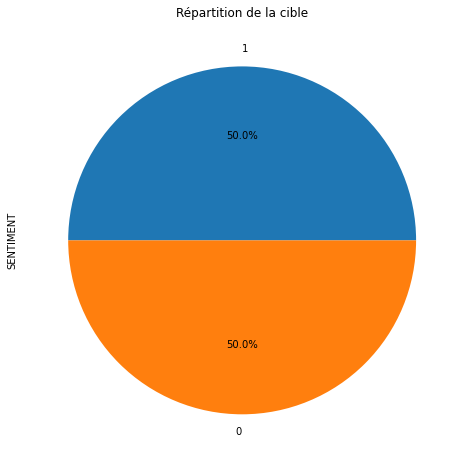

<IPython.core.display.Javascript object>

In [41]:
_ = (
    df_val["SENTIMENT"]
    .value_counts()
    .plot(
        kind="pie", figsize=(10, 8), autopct="%1.1f%%", title="Répartition de la cible"
    )
)

>## <span style='color:#1e488f' >Création des DataFrame `Train` et `Test`</span>

In [42]:
df_train, df_test = train_test_split(
    df_tweets, stratify=df_tweets["SENTIMENT"], train_size=0.8, random_state=SEED
)

<IPython.core.display.Javascript object>

In [43]:
df_train = df_train.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [44]:
df_train

,SENTIMENT,TWEET
0,1,@lauracowen hope you customised it with #ubunt...
1,0,Ultrasound shows something stuck in his intest...
2,0,@tinasays i forgot to take a pic and my nickn...
3,0,Coachella is coming to a close
4,0,Finally got a new car!!! can't drive it yet th...
...,...,...
82395,0,Juuust woke up and there's nothing to do
82396,1,Got some sweet shopping done in NY today at th...
82397,0,First time I'm going home early sucks to b si...
82398,1,@recessionipes ...although in my poor post-col...


<IPython.core.display.Javascript object>

#### Taille du jeu 'Train'

In [45]:
len(df_train["SENTIMENT"])

82400

<IPython.core.display.Javascript object>

#### Répartition du jeu 'Train'

In [46]:
df_train["SENTIMENT"].value_counts()

1    41200
0    41200
Name: SENTIMENT, dtype: int64

<IPython.core.display.Javascript object>

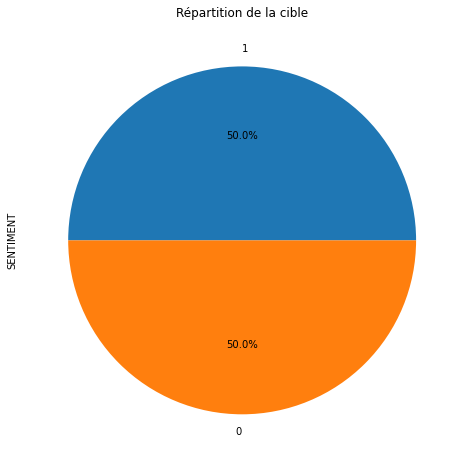

<IPython.core.display.Javascript object>

In [47]:
_ = (
    df_train["SENTIMENT"]
    .value_counts()
    .plot(
        kind="pie", figsize=(10, 8), autopct="%1.1f%%", title="Répartition de la cible"
    )
)

In [48]:
df_test = df_test.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [49]:
df_test

,SENTIMENT,TWEET
0,1,Finish line for Team Alpha 'Allstars'.. Was a ...
1,1,@souljaboytellem &amp;nd what is it that your ...
2,1,@Llubyloo as long as that is all you are tweek...
3,1,@mileycyrus I agree just kick back and relax
4,1,@jonsoklahomagrl you gonna stay up and wait fo...
...,...,...
20595,1,"hey smile, i wont to get chineses eyed, cant w..."
20596,0,http://twitpic.com/6ivh3 - I have my earphones...
20597,1,I'm looking forward to my 1st field hockey mat...
20598,0,@xohillary well I would love to hang out w/ yo...


<IPython.core.display.Javascript object>

#### Taille du jeu 'Test'

In [50]:
len(df_test["SENTIMENT"])

20600

<IPython.core.display.Javascript object>

#### Répartition du jeu 'Test'

In [51]:
df_test["SENTIMENT"].value_counts()

1    10300
0    10300
Name: SENTIMENT, dtype: int64

<IPython.core.display.Javascript object>

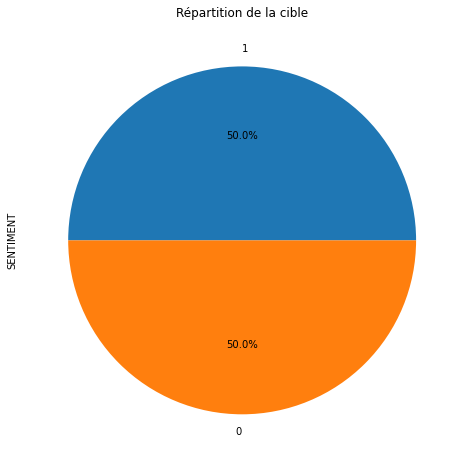

<IPython.core.display.Javascript object>

In [52]:
_ = (
    df_test["SENTIMENT"]
    .value_counts()
    .plot(
        kind="pie", figsize=(10, 8), autopct="%1.1f%%", title="Répartition de la cible"
    )
)

>## <span style='color:#1e488f' >Création du DataFrame `Train_sample`</span>

In [53]:
SAMPLE_SIZE = 40000

<IPython.core.display.Javascript object>

In [54]:
df_train_sample, _ = train_test_split(
    df_train, stratify=df_train["SENTIMENT"], train_size=SAMPLE_SIZE, random_state=SEED
)

<IPython.core.display.Javascript object>

In [55]:
df_train_sample = df_train_sample.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [56]:
df_train_sample

,SENTIMENT,TWEET
0,0,Ahhhhhh someone help me get picked up from her...
1,0,just found out an old friend of mine passed away
2,1,@PhillyD I love your show! I've subscribed and...
3,0,@percussionpanda I hvent gotten a response yet...
4,0,He's on his way back to Keningau.. Hopefully h...
...,...,...
39995,0,@ MGiraudOfficial yes u are &amp; ur fans are ...
39996,0,@Ashalee22 Why did no one tell me there was go...
39997,1,@WilliamOrbit have you ever tried an Alesis An...
39998,1,@mgrmike Hi Mike! I would love for you to dow...


<IPython.core.display.Javascript object>

#### Taille du jeu 'Train_sample'

In [57]:
len(df_train_sample["SENTIMENT"])

40000

<IPython.core.display.Javascript object>

#### Répartition du jeu 'Train_sample'

In [58]:
df_train_sample["SENTIMENT"].value_counts()

0    20000
1    20000
Name: SENTIMENT, dtype: int64

<IPython.core.display.Javascript object>

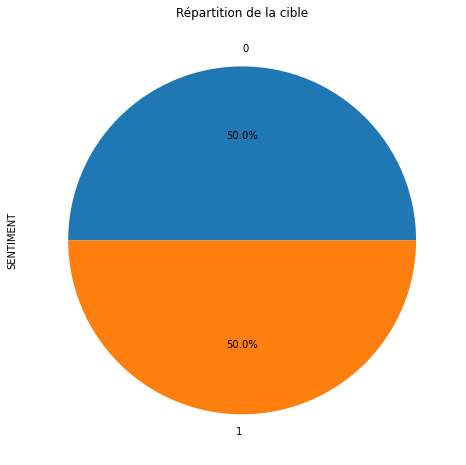

<IPython.core.display.Javascript object>

In [59]:
_ = (
    df_train_sample["SENTIMENT"]
    .value_counts()
    .plot(
        kind="pie", figsize=(10, 8), autopct="%1.1f%%", title="Répartition de la cible"
    )
)

 # <span style='color:blue' id="section_2" >2. Preprocessing des données textuelles</span>
- Nous avons mis en place deux techniques de prétraitement :
    - Nettoyage des Tweets avec la librairie 'Preprocessor'
    - Lemmatization des Tweets avec la librairie 'SpaCy'

>## <span style='color:green' id="section_2_1" >2.1. Nettoyage des Tweets avec la librairie 'Preprocess'</span>

- Cette librairie Python est spécialisée dans le prétraitement des Tweets
- Celle-ci permet de nettoyer les Tweets finement : on peut supprimer les éléments superflus des Tweets selon le besoin
- Nous avons essayé deux types de nettoyage :
    - Nettoyage 'complet' : consiste à enlever tous les éléments superflus
    - Nettoyage 'léger' : consiste à enlever uniquement les éléments de type URL et EMOJI

### PreProcessing 'Complet'

#### Exemple de nettoyage

In [60]:
tweetpreprocessor.clean("Preprocessor is #awesome 👍 https://github.com/s/preprocessor")

'Preprocessor is'

<IPython.core.display.Javascript object>

#### PreProcessing DataFrame 'Train'

In [61]:
df_train["TWEET_PREPROCESSED"] = df_train["TWEET"].map(
    lambda text: tweetpreprocessor.clean(text)
)

<IPython.core.display.Javascript object>

In [62]:
df_train

,SENTIMENT,TWEET,TWEET_PREPROCESSED
0,1,@lauracowen hope you customised it with #ubunt...,hope you customised it with / wallpapers and l...
1,0,Ultrasound shows something stuck in his intest...,Ultrasound shows something stuck in his intest...
2,0,@tinasays i forgot to take a pic and my nickn...,i forgot to take a pic and my nickname was rob...
3,0,Coachella is coming to a close,Coachella is coming to a close
4,0,Finally got a new car!!! can't drive it yet th...,Finally got a new car!!! can't drive it yet th...
...,...,...,...
82395,0,Juuust woke up and there's nothing to do,Juuust woke up and there's nothing to do
82396,1,Got some sweet shopping done in NY today at th...,Got some sweet shopping done in NY today at th...
82397,0,First time I'm going home early sucks to b si...,First time I'm going home early sucks to b sin...
82398,1,@recessionipes ...although in my poor post-col...,...although in my poor post-college days I has...


<IPython.core.display.Javascript object>

In [63]:
X_train = df_train["TWEET_PREPROCESSED"].values
y_train = df_train["SENTIMENT"].values

<IPython.core.display.Javascript object>

In [64]:
print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

X_train Shape: (82400,)
y_train Shape: (82400,)


<IPython.core.display.Javascript object>

In [65]:
X_train

array(['hope you customised it with / wallpapers and left podcasts on the desktop Never hurts to advertise',
       'Ultrasound shows something stuck in his intestines. Time for surgery.',
       'i forgot to take a pic and my nickname was robinsprkl. hahahaha',
       ...,
       "First time I'm going home early sucks to b single no one to call",
       '...although in my poor post-college days I has a suite of dried out cheese &amp; limp veggies recipes. Nasty stuff.',
       'lol.....yes!!! cant seem to get a profile picture up tho how are you?'],
      dtype=object)

<IPython.core.display.Javascript object>

In [66]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

<IPython.core.display.Javascript object>

#### Sauvegarde du DataFrame 'Train'

In [67]:
df_train.to_csv("airparadis_train_dataset.csv", index=False)

<IPython.core.display.Javascript object>

#### PreProcessing DataFrame 'Train_sample'

In [68]:
df_train_sample["TWEET_PREPROCESSED"] = df_train_sample["TWEET"].map(
    lambda text: tweetpreprocessor.clean(text)
)

<IPython.core.display.Javascript object>

In [69]:
df_train_sample

,SENTIMENT,TWEET,TWEET_PREPROCESSED
0,0,Ahhhhhh someone help me get picked up from her...,Ahhhhhh someone help me get picked up from her...
1,0,just found out an old friend of mine passed away,just found out an old friend of mine passed away
2,1,@PhillyD I love your show! I've subscribed and...,I love your show! I've subscribed and followin...
3,0,@percussionpanda I hvent gotten a response yet...,I hvent gotten a response yet I dnt think I wi...
4,0,He's on his way back to Keningau.. Hopefully h...,He's on his way back to Keningau.. Hopefully h...
...,...,...,...
39995,0,@ MGiraudOfficial yes u are &amp; ur fans are ...,MGiraudOfficial yes u are &amp; ur fans are ex...
39996,0,@Ashalee22 Why did no one tell me there was go...,Why did no one tell me there was going to be a...
39997,1,@WilliamOrbit have you ever tried an Alesis An...,have you ever tried an Alesis Andromeda A6?
39998,1,@mgrmike Hi Mike! I would love for you to dow...,Hi Mike! I would love for you to download my c...


<IPython.core.display.Javascript object>

In [70]:
X_train_sample = df_train_sample["TWEET_PREPROCESSED"].values
y_train_sample = df_train_sample["SENTIMENT"].values

<IPython.core.display.Javascript object>

In [71]:
print("X_train_sample Shape:", X_train_sample.shape)
print("y_train_sample Shape:", y_train_sample.shape)

X_train_sample Shape: (40000,)
y_train_sample Shape: (40000,)


<IPython.core.display.Javascript object>

In [72]:
X_train_sample

array(["Ahhhhhh someone help me get picked up from here! No one's picking up the phone",
       'just found out an old friend of mine passed away',
       "I love your show! I've subscribed and following your tweets. Can't wait to see more",
       ..., 'have you ever tried an Alesis Andromeda A6?',
       "Hi Mike! I would love for you to download my cd, &quot;bend&quot;, for $4 You'll luv it!",
       'I throw dinner parties like I have space for but comfortably can only fit .'],
      dtype=object)

<IPython.core.display.Javascript object>

In [73]:
y_train_sample

array([0, 0, 1, ..., 1, 1, 0])

<IPython.core.display.Javascript object>

##### X_train_sample_notpreprocessed : version avec tweets non pré processés pour comparaison des résulats

In [74]:
X_train_sample_notpreprocessed = df_train_sample["TWEET"].values

<IPython.core.display.Javascript object>

#### PreProcessing DataFrame 'Test'

In [75]:
df_test["TWEET_PREPROCESSED"] = df_test["TWEET"].map(
    lambda text: tweetpreprocessor.clean(text)
)

<IPython.core.display.Javascript object>

In [76]:
df_test

,SENTIMENT,TWEET,TWEET_PREPROCESSED
0,1,Finish line for Team Alpha 'Allstars'.. Was a ...,Finish line for Team Alpha 'Allstars'.. Was a ...
1,1,@souljaboytellem &amp;nd what is it that your ...,&amp;nd what is it that your doin Dre?? lol
2,1,@Llubyloo as long as that is all you are tweek...,as long as that is all you are tweeking Lin
3,1,@mileycyrus I agree just kick back and relax,I agree just kick back and relax
4,1,@jonsoklahomagrl you gonna stay up and wait fo...,you gonna stay up and wait for him tonight
...,...,...,...
20595,1,"hey smile, i wont to get chineses eyed, cant w...","hey smile, i wont to get chineses eyed, cant w..."
20596,0,http://twitpic.com/6ivh3 - I have my earphones...,- I have my earphones back! ah... the depth of...
20597,1,I'm looking forward to my 1st field hockey mat...,I'm looking forward to my st field hockey match.
20598,0,@xohillary well I would love to hang out w/ yo...,well I would love to hang out w/ you! Only pro...


<IPython.core.display.Javascript object>

In [77]:
X_test = df_test["TWEET_PREPROCESSED"].values
y_test = df_test["SENTIMENT"].values

<IPython.core.display.Javascript object>

In [78]:
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)

X_test Shape: (20600,)
y_test Shape: (20600,)


<IPython.core.display.Javascript object>

In [79]:
X_test

array(["Finish line for Team Alpha 'Allstars'.. Was a great day and good to in the winning company team",
       '&amp;nd what is it that your doin Dre?? lol',
       'as long as that is all you are tweeking Lin', ...,
       "I'm looking forward to my st field hockey match.",
       "well I would love to hang out w/ you! Only problem is right now I don't have a car since I am just visitin",
       "he he heey ... how are you? watching MTV... aren't they going bankrupt? at least vh1 still going... &lt;-bored as u can see."],
      dtype=object)

<IPython.core.display.Javascript object>

In [80]:
y_test

array([1, 1, 1, ..., 1, 0, 0])

<IPython.core.display.Javascript object>

#### PreProcessing DataFrame 'Validation'

In [81]:
df_val["TWEET_PREPROCESSED"] = df_val["TWEET"].map(
    lambda text: tweetpreprocessor.clean(text)
)

<IPython.core.display.Javascript object>

In [82]:
df_val

,SENTIMENT,TWEET,TWEET_PREPROCESSED
0,1,@OsmentEmily hey how are you?,hey how are you?
1,0,@KimBlairwitch - Not possible whilst live on t...,- Not possible whilst live on the show i'm afraid
2,1,@NSpirit You have such a baby face!,You have such a baby face!
3,0,@zanyalves eu tb,eu tb
4,0,@aliceirene I do!! I'm not in yo citaaay thou...,I do!! I'm not in yo citaaay though.
...,...,...,...
34995,1,@dbldbl no not yet...,no not yet...
34996,1,@kyleandjackieo yea rove is on,yea rove is on
34997,1,InTheSpotlight with adri&amp;kent yeee!,InTheSpotlight with adri&amp;kent yeee!
34998,1,@mileycyrus Miley! Please tell everyone to bu...,Miley! Please tell everyone to buy Girls Aloud...


<IPython.core.display.Javascript object>

In [83]:
X_val = df_val["TWEET_PREPROCESSED"].values
y_val = df_val["SENTIMENT"].values

<IPython.core.display.Javascript object>

In [84]:
print("X_val Shape:", X_val.shape)
print("y_val Shape:", y_val.shape)

X_val Shape: (35000,)
y_val Shape: (35000,)


<IPython.core.display.Javascript object>

In [85]:
X_val

array(['hey how are you?',
       "- Not possible whilst live on the show i'm afraid",
       'You have such a baby face!', ...,
       'InTheSpotlight with adri&amp;kent yeee!',
       'Miley! Please tell everyone to buy Girls Aloud Untouchable! Every tweet helps ty',
       "BOSA SI SWA!! haha that's a STUDY DRINK! haha btw! good luck with your final tomorrow dude!"],
      dtype=object)

<IPython.core.display.Javascript object>

In [86]:
y_val

array([1, 0, 1, ..., 1, 1, 1])

<IPython.core.display.Javascript object>

##### X_val_notpreprocessed : version avec tweets non préprocessés pour comparaison des résulats

In [87]:
X_val_notpreprocessed = df_val["TWEET"].values

<IPython.core.display.Javascript object>

#### PreProcessing DataFrame 'Approach'

In [88]:
df_app["TWEET_PREPROCESSED"] = df_app["TWEET"].map(
    lambda text: tweetpreprocessor.clean(text)
)

<IPython.core.display.Javascript object>

In [89]:
df_app

,SENTIMENT,TWEET,TWEET_PREPROCESSED
0,1,@seanlb Got them all,Got them all
1,0,On my way in to the office...raining,On my way in to the office...raining
2,0,going to my cousin's funeral,going to my cousin's funeral
3,1,@ShannonRenee,
4,0,Downloading the final iPhone 3.0 SDK from Appl...,Downloading the final iPhone SDK from Apple at...
...,...,...,...
1995,1,haha I know all the conversations and I could ...,haha I know all the conversations and I could ...
1996,0,"Missing my phone, which is at the bottom of th...","Missing my phone, which is at the bottom of th..."
1997,0,Please noooo...Dave Gahan has cancer scare,Please noooo...Dave Gahan has cancer scare
1998,0,"@ravenme in NYC, you don't have to shoot yours...","in NYC, you don't have to shoot yourself -- pl..."


<IPython.core.display.Javascript object>

In [90]:
X_app = df_app["TWEET_PREPROCESSED"].values
y_app = df_app["SENTIMENT"].values

<IPython.core.display.Javascript object>

In [91]:
print("X_app Shape:", X_app.shape)
print("y_app Shape:", y_app.shape)

X_app Shape: (2000,)
y_app Shape: (2000,)


<IPython.core.display.Javascript object>

In [92]:
X_app

array(['Got them all', 'On my way in to the office...raining',
       "going to my cousin's funeral", ...,
       'Please noooo...Dave Gahan has cancer scare',
       "in NYC, you don't have to shoot yourself -- plenty of other folks willing to do it for you.",
       'Going to the city to babysit for hours... At :45 in the morning.'],
      dtype=object)

<IPython.core.display.Javascript object>

In [93]:
y_app

array([1, 0, 0, ..., 0, 0, 0])

<IPython.core.display.Javascript object>

#### Sauvegarde du DataFrame 'Approach'

In [94]:
df_app.to_csv("airparadis_approach_dataset.csv", index=False)

<IPython.core.display.Javascript object>

### PreProcessing 'Léger'

In [95]:
tweetpreprocessor.set_options(tweetpreprocessor.OPT.URL, tweetpreprocessor.OPT.EMOJI)

<IPython.core.display.Javascript object>

In [96]:
tweetpreprocessor.clean("Preprocessor is #awesome 👍 https://github.com/s/preprocessor")

'Preprocessor is #awesome'

<IPython.core.display.Javascript object>

In [97]:
df_train_sample["TWEET_LIGHT_PREPROCESSED"] = df_train_sample["TWEET"].apply(
    lambda text: tweetpreprocessor.clean(text)
)

<IPython.core.display.Javascript object>

In [98]:
df_train_sample

,SENTIMENT,TWEET,TWEET_PREPROCESSED,TWEET_LIGHT_PREPROCESSED
0,0,Ahhhhhh someone help me get picked up from her...,Ahhhhhh someone help me get picked up from her...,Ahhhhhh someone help me get picked up from her...
1,0,just found out an old friend of mine passed away,just found out an old friend of mine passed away,just found out an old friend of mine passed away
2,1,@PhillyD I love your show! I've subscribed and...,I love your show! I've subscribed and followin...,@PhillyD I love your show! I've subscribed and...
3,0,@percussionpanda I hvent gotten a response yet...,I hvent gotten a response yet I dnt think I wi...,@percussionpanda I hvent gotten a response yet...
4,0,He's on his way back to Keningau.. Hopefully h...,He's on his way back to Keningau.. Hopefully h...,He's on his way back to Keningau.. Hopefully h...
...,...,...,...,...
39995,0,@ MGiraudOfficial yes u are &amp; ur fans are ...,MGiraudOfficial yes u are &amp; ur fans are ex...,@ MGiraudOfficial yes u are &amp; ur fans are ...
39996,0,@Ashalee22 Why did no one tell me there was go...,Why did no one tell me there was going to be a...,@Ashalee22 Why did no one tell me there was go...
39997,1,@WilliamOrbit have you ever tried an Alesis An...,have you ever tried an Alesis Andromeda A6?,@WilliamOrbit have you ever tried an Alesis An...
39998,1,@mgrmike Hi Mike! I would love for you to dow...,Hi Mike! I would love for you to download my c...,@mgrmike Hi Mike! I would love for you to down...


<IPython.core.display.Javascript object>

In [99]:
X_train_sample_lightpreprocessed = df_train_sample["TWEET_LIGHT_PREPROCESSED"].values

<IPython.core.display.Javascript object>

In [100]:
df_val["TWEET_LIGHT_PREPROCESSED"] = df_val["TWEET"].map(
    lambda text: tweetpreprocessor.clean(text)
)

<IPython.core.display.Javascript object>

In [101]:
df_val

,SENTIMENT,TWEET,TWEET_PREPROCESSED,TWEET_LIGHT_PREPROCESSED
0,1,@OsmentEmily hey how are you?,hey how are you?,@OsmentEmily hey how are you?
1,0,@KimBlairwitch - Not possible whilst live on t...,- Not possible whilst live on the show i'm afraid,@KimBlairwitch - Not possible whilst live on t...
2,1,@NSpirit You have such a baby face!,You have such a baby face!,@NSpirit You have such a baby face!
3,0,@zanyalves eu tb,eu tb,@zanyalves eu tb
4,0,@aliceirene I do!! I'm not in yo citaaay thou...,I do!! I'm not in yo citaaay though.,@aliceirene I do!! I'm not in yo citaaay though.
...,...,...,...,...
34995,1,@dbldbl no not yet...,no not yet...,@dbldbl no not yet...
34996,1,@kyleandjackieo yea rove is on,yea rove is on,@kyleandjackieo yea rove is on
34997,1,InTheSpotlight with adri&amp;kent yeee!,InTheSpotlight with adri&amp;kent yeee!,InTheSpotlight with adri&amp;kent yeee!
34998,1,@mileycyrus Miley! Please tell everyone to bu...,Miley! Please tell everyone to buy Girls Aloud...,@mileycyrus Miley! Please tell everyone to buy...


<IPython.core.display.Javascript object>

In [102]:
X_val_lightpreprocessed = df_val["TWEET_LIGHT_PREPROCESSED"].values

<IPython.core.display.Javascript object>

>## <span style='color:green' id="section_2_2" >2.2. Lemmatization des Tweets avec la librairie `SpaCy`</span>

In [103]:
def lemmatization(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return " ".join(tokens)

<IPython.core.display.Javascript object>

In [104]:
df_train_sample["TWEET_LEMMATIZED"] = df_train_sample["TWEET_PREPROCESSED"].apply(
    lambda text: lemmatization(text)
)

<IPython.core.display.Javascript object>

In [105]:
df_train_sample

,SENTIMENT,TWEET,TWEET_PREPROCESSED,TWEET_LIGHT_PREPROCESSED,TWEET_LEMMATIZED
0,0,Ahhhhhh someone help me get picked up from her...,Ahhhhhh someone help me get picked up from her...,Ahhhhhh someone help me get picked up from her...,Ahhhhhh someone help I get pick up from here !...
1,0,just found out an old friend of mine passed away,just found out an old friend of mine passed away,just found out an old friend of mine passed away,just find out an old friend of mine pass away
2,1,@PhillyD I love your show! I've subscribed and...,I love your show! I've subscribed and followin...,@PhillyD I love your show! I've subscribed and...,I love your show ! I 've subscribe and follow ...
3,0,@percussionpanda I hvent gotten a response yet...,I hvent gotten a response yet I dnt think I wi...,@percussionpanda I hvent gotten a response yet...,I hvent get a response yet I dnt think I will ...
4,0,He's on his way back to Keningau.. Hopefully h...,He's on his way back to Keningau.. Hopefully h...,He's on his way back to Keningau.. Hopefully h...,he be on his way back to Keningau .. hopefully...
...,...,...,...,...,...
39995,0,@ MGiraudOfficial yes u are &amp; ur fans are ...,MGiraudOfficial yes u are &amp; ur fans are ex...,@ MGiraudOfficial yes u are &amp; ur fans are ...,MGiraudOfficial yes u be & amp ; ur fan be exc...
39996,0,@Ashalee22 Why did no one tell me there was go...,Why did no one tell me there was going to be a...,@Ashalee22 Why did no one tell me there was go...,why do no one tell I there be go to be a seque...
39997,1,@WilliamOrbit have you ever tried an Alesis An...,have you ever tried an Alesis Andromeda A6?,@WilliamOrbit have you ever tried an Alesis An...,have you ever try an Alesis Andromeda A6 ?
39998,1,@mgrmike Hi Mike! I would love for you to dow...,Hi Mike! I would love for you to download my c...,@mgrmike Hi Mike! I would love for you to down...,hi Mike ! I would love for you to download my ...


<IPython.core.display.Javascript object>

In [106]:
X_train_sample_lemma = df_train_sample["TWEET_LEMMATIZED"].values

<IPython.core.display.Javascript object>

In [107]:
X_train_sample_lemma

array(["Ahhhhhh someone help I get pick up from here ! no one 's pick up the phone",
       'just find out an old friend of mine pass away',
       "I love your show ! I 've subscribe and follow your tweet . can not wait to see more",
       ..., 'have you ever try an Alesis Andromeda A6 ?',
       'hi Mike ! I would love for you to download my cd , & quot;bend&quot ; , for $ 4 you will luv it !',
       'I throw dinner party like I have space for but comfortably can only fit .'],
      dtype=object)

<IPython.core.display.Javascript object>

In [108]:
df_val["TWEET_LEMMATIZED"] = df_val["TWEET_PREPROCESSED"].map(
    lambda text: lemmatization(text)
)

<IPython.core.display.Javascript object>

In [109]:
X_val_lemma = df_val["TWEET_LEMMATIZED"].values

<IPython.core.display.Javascript object>

In [110]:
X_val_lemma

array(['hey how be you ?',
       '- not possible whilst live on the show I be afraid',
       'you have such a baby face !', ...,
       'InTheSpotlight with adri&amp;kent yeee !',
       'Miley ! please tell everyone to buy Girls Aloud Untouchable ! every tweet help ty',
       'BOSA SI SWA ! ! haha that be a STUDY DRINK ! haha btw ! good luck with your final tomorrow dude !'],
      dtype=object)

<IPython.core.display.Javascript object>

### Fonction de suppression manuelles des : hashtags, @ and url
##### Remarque :
- On peut également effectuer un préprocessing 'manuel' des tweets grâce à la fonction ci-dessous qui permet de supprimer les élements liés à la liste 'character_list'

In [111]:
def remove_word_with_chararcter(text, character_list):
    # Remove words in a text that contains a char from the list.
    text = text.split()
    result = [
        element
        for element in text
        if all(character not in element for character in character_list)
    ]
    text_cleaned = " ".join(result)
    return text_cleaned

<IPython.core.display.Javascript object>

In [112]:
character_list = ["@", "#", "http", "www", "/"]

<IPython.core.display.Javascript object>

 # <span style='color:blue' id="section_3" >3. Approche Machine Learning classique = modèle de référence</span>

 - Choix de la métrique d'évaluation
 - Représentation des données textuelles : TF-IDF
 - Modélisation : Regression logistique
 - Evaluation

- Cette approche va nous permettre de mettre en place un modèle basique de référence qui nous servira de comparaison pour évaluer la performance des modèles plus complexes basés sur l'approche Deep Learning (Réseaux de neurones)

>## <span style='color:green' id="section_3_1" >3.1. Choix de la métrique d'évaluation</span>
- Nous avons choisi la métrique **Accuracy**, car : 
    - Les données sont équlibrées
    - Il faut déterminer les sentiments corrects à égalité, qu'ils soient positifs ou négatifs

>## <span style='color:green' id="section_3_2" >3.2. Modélisation des Tweets nettoyés mais non lemmatisés</span>

>>## <span style='color:#D15C22' id="section_3_2_1" >3.2.1 Représentation des données textuelles : TF-IDF</span>

In [113]:
tfidf_model = TfidfVectorizer()

<IPython.core.display.Javascript object>

In [114]:
tfidf_skl = tfidf_model.fit_transform(X_train_sample)

<IPython.core.display.Javascript object>

In [115]:
tfidf_skl

<40000x30510 sparse matrix of type '<class 'numpy.float64'>'
	with 447208 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

#### Taille du vocabulaire

In [116]:
len(tfidf_model.vocabulary_)

30510

<IPython.core.display.Javascript object>

#### Vocabulaire

In [117]:
tfidf_model.vocabulary_

{'ahhhhhh': 780,
 'someone': 24417,
 'help': 11979,
 'me': 16399,
 'get': 10570,
 'picked': 19802,
 'up': 28083,
 'from': 10105,
 'here': 12021,
 'no': 18119,
 'one': 18684,
 'picking': 19806,
 'the': 26416,
 'phone': 19740,
 'just': 14079,
 'found': 9897,
 'out': 18948,
 'an': 1197,
 'old': 18624,
 'friend': 10063,
 'of': 18508,
 'mine': 16811,
 'passed': 19363,
 'away': 2000,
 'love': 15640,
 'your': 30199,
 'show': 23666,
 've': 28328,
 'subscribed': 25404,
 'and': 1226,
 'following': 9773,
 'tweets': 27532,
 'can': 4240,
 'wait': 28745,
 'to': 26840,
 'see': 23120,
 'more': 17184,
 'hvent': 12714,
 'gotten': 10969,
 'response': 21969,
 'yet': 30119,
 'dnt': 7451,
 'think': 26507,
 'will': 29379,
 'now': 18303,
 'especially': 8675,
 'with': 29490,
 'all': 967,
 'stuff': 25345,
 'his': 12182,
 'dad': 6484,
 'going': 10839,
 'on': 18681,
 'poor': 20226,
 'thing': 26499,
 'he': 11800,
 'way': 28948,
 'back': 2147,
 'keningau': 14289,
 'hopefully': 12398,
 'reach': 21440,
 'there': 2645

<IPython.core.display.Javascript object>

>>## <span style='color:#D15C22' id="section_3_2_2" >3.2.2 Modélisation : Regression logistique</span>

In [118]:
log_reg_model = LogisticRegression(random_state=SEED)

<IPython.core.display.Javascript object>

In [119]:
log_tfidf_model = Pipeline([("vect", tfidf_model), ("clf", log_reg_model)])

<IPython.core.display.Javascript object>

In [120]:
log_tfidf_model.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=0))])

<IPython.core.display.Javascript object>

>>## <span style='color:#D15C22' id="section_3_2_3" >3.2.3 Evaluation</span>
### <span style='color:#6A00B3 '>Accuracy score :</span>

In [121]:
log_tfidf_model_accuracy = log_tfidf_model.score(X_val, y_val)

<IPython.core.display.Javascript object>

In [122]:
print(f"Accuracy score = {log_tfidf_model_accuracy:.3f}")

Accuracy score = 0.774


<IPython.core.display.Javascript object>

### <span style='color:#6A00B3 '> Prédictions :</span>

In [123]:
predicted_labels = log_tfidf_model.predict(X_val)
predicted_labels

array([1, 0, 0, ..., 1, 1, 1])

<IPython.core.display.Javascript object>

### <span style='color:#6A00B3 '>Matrice de confusion :</span>

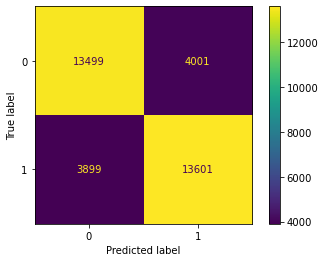

<IPython.core.display.Javascript object>

In [124]:
cm = confusion_matrix(y_val, predicted_labels)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

### <span style='color:#6A00B3 '>Rapport de classifiction :</span>

In [125]:
print(classification_report(y_val, predicted_labels))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77     17500
           1       0.77      0.78      0.77     17500

    accuracy                           0.77     35000
   macro avg       0.77      0.77      0.77     35000
weighted avg       0.77      0.77      0.77     35000



<IPython.core.display.Javascript object>

>## <span style='color:green' id="section_3_3" >3.3. Modélisation des Tweets nettoyés et lemmatisés</span>

>>## <span style='color:#D15C22' id="section_3_3_1" >3.3.1 Représentation des données textuelles : TF-IDF</span>

In [126]:
tfidf_lemma_model = TfidfVectorizer()

<IPython.core.display.Javascript object>

In [127]:
tfidf_lemma_skl = tfidf_lemma_model.fit_transform(X_train_sample_lemma)

<IPython.core.display.Javascript object>

In [128]:
tfidf_lemma_skl

<40000x27066 sparse matrix of type '<class 'numpy.float64'>'
	with 447085 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

#### Taille du vocabulaire

In [129]:
len(tfidf_lemma_model.vocabulary_)

27066

<IPython.core.display.Javascript object>

#### Vocabulaire

In [130]:
tfidf_lemma_model.vocabulary_

{'ahhhhhh': 691,
 'someone': 21662,
 'help': 10590,
 'get': 9316,
 'pick': 17752,
 'up': 24856,
 'from': 8893,
 'here': 10630,
 'no': 16238,
 'one': 16759,
 'the': 23359,
 'phone': 17701,
 'just': 12518,
 'find': 8345,
 'out': 17004,
 'an': 1079,
 'old': 16701,
 'friend': 8854,
 'of': 16595,
 'mine': 15022,
 'pass': 17369,
 'away': 1797,
 'love': 13931,
 'your': 26762,
 'show': 21027,
 've': 25078,
 'subscribe': 22483,
 'and': 1106,
 'follow': 8585,
 'tweet': 24302,
 'can': 3778,
 'not': 16369,
 'wait': 25458,
 'to': 23728,
 'see': 20559,
 'more': 15368,
 'hvent': 11258,
 'response': 19555,
 'yet': 26688,
 'dnt': 6561,
 'think': 23441,
 'will': 26017,
 'now': 16405,
 'especially': 7646,
 'with': 26112,
 'all': 865,
 'stuff': 22435,
 'his': 10779,
 'dad': 5711,
 'go': 9519,
 'on': 16756,
 'poor': 18116,
 'thing': 23433,
 'he': 10426,
 'be': 2267,
 'way': 25634,
 'back': 1941,
 'keningau': 12717,
 'hopefully': 10979,
 'reach': 19151,
 'there': 23394,
 'safely': 20134,
 'feel': 8179,
 're

<IPython.core.display.Javascript object>

>>## <span style='color:#D15C22' id="section_3_3_2" >3.3.2 Modélisation : Regression logistique</span>

In [131]:
log_reg_lemma_model = LogisticRegression(random_state=SEED)

<IPython.core.display.Javascript object>

In [132]:
log_tfidf_lemma_model = Pipeline(
    [("vect", tfidf_lemma_model), ("clf", log_reg_lemma_model)]
)

<IPython.core.display.Javascript object>

In [133]:
log_tfidf_lemma_model.fit(X_train_sample_lemma, y_train_sample)

Pipeline(steps=[('vect', TfidfVectorizer()),
                ('clf', LogisticRegression(random_state=0))])

<IPython.core.display.Javascript object>

>>## <span style='color:#D15C22' id="section_3_3_3" >3.3.3  Evaluation</span>

### <span style='color:#6A00B3 '>Accuracy score :</span>

In [134]:
log_tfidf_lemma_model_accuracy = log_tfidf_lemma_model.score(X_val_lemma, y_val)

<IPython.core.display.Javascript object>

In [135]:
print(f"Accuracy score = {log_tfidf_lemma_model_accuracy:.4f}")

Accuracy score = 0.7714


<IPython.core.display.Javascript object>

### <span style='color:#6A00B3 '>Prédictions :</span>

In [136]:
predicted_labels_lemma = log_tfidf_lemma_model.predict(X_val_lemma)
predicted_labels_lemma

array([1, 0, 1, ..., 1, 1, 1])

<IPython.core.display.Javascript object>

### <span style='color:#6A00B3 '>Matrice de confusion :</span>

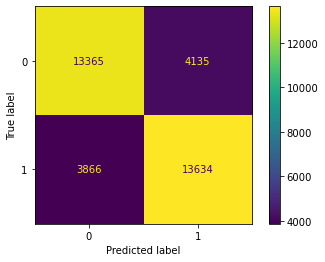

<IPython.core.display.Javascript object>

In [137]:
cm = confusion_matrix(y_val, predicted_labels_lemma)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

### <span style='color:#6A00B3 '>Rapport de classifiction :</span>

In [138]:
print(classification_report(y_val, predicted_labels_lemma))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     17500
           1       0.77      0.78      0.77     17500

    accuracy                           0.77     35000
   macro avg       0.77      0.77      0.77     35000
weighted avg       0.77      0.77      0.77     35000



<IPython.core.display.Javascript object>

### <span style='color:#019DA0'>Synthèse :</span>
- La lemmatisation n'améliore pas les résultats : l'accuracy avec les Tweets lemmatises (0.771) est légèrement inférieure à l'accuracy avec les Tweets non lemmatises (0.774) => Le nettoyage avec la librairie tweet-preprocessor est assez performant.
- Cette approche nous a permis de mettre en place un modèle basique de référence qui nous servira de comparaison pour évaluer la performance des modèles plus complexes basés sur l'approche Deep Learning (Réseaux de neurones).
- L'accuracy du modèle de référence est de **0.774**.

 # <span style='color:blue' id="section_4" >4. Approche Deep Learning = modèles avancés</span>

>## <span style='color:green' id="section_4_1" >4.1. Représentation des données textuelles : Words Embeddings</span>

- Nous allons utiliser un modèle de type GloVe classique **préentraîné**.

>>## <span style='color:#D15C22' id="section_4_1_1" >4.1.1 Modèle GloVe 'classique' préentraîné</span>

#### Chargement du modèle : GloVe word embedding 6-billion and 300-dimensional text
- Construction du dictionnaire contenant chaque mot (clé) et son vector embedding (valeur)
- Taille des vecteurs GloVe = 300

In [139]:
glove_embeddings_index = {}

with open(path_dataset + "glove.6B.300d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        glove_embeddings_index[word] = coefs
    f.close()

print("Found %s word vectors." % len(glove_embeddings_index))

Found 400000 word vectors.


<IPython.core.display.Javascript object>

#### Taille du dictionnaire du modèle GloVe

In [140]:
len(glove_embeddings_index)

400000

<IPython.core.display.Javascript object>

#### Taille des vecteurs de mots du modèle GloVe

In [141]:
len(glove_embeddings_index["really"])

300

<IPython.core.display.Javascript object>

#### Exemple de vecteur de mot

In [142]:
glove_embeddings_index["really"]

array([ 0.076563 ,  0.032454 , -0.030982 , -0.018969 ,  0.23847  ,
        0.0068223, -0.10712  ,  0.071476 ,  0.09306  , -2.0062   ,
        0.36672  , -0.26163  ,  0.079668 ,  0.29697  , -0.39083  ,
       -0.11541  , -0.12517  , -0.076881 ,  0.10232  ,  0.49871  ,
        0.39728  ,  0.84999  ,  0.26828  , -0.16472  , -0.2239   ,
        0.013359 ,  0.20367  , -0.56752  ,  0.090597 , -0.14017  ,
       -0.091364 ,  0.30727  , -0.79903  , -0.33384  , -1.5976   ,
        0.51233  , -0.062729 ,  0.23001  ,  0.17198  , -0.0037873,
        0.11718  , -0.57576  ,  0.091715 , -0.38781  ,  0.11705  ,
        0.2184   ,  0.24388  , -0.10923  ,  0.16841  ,  0.14458  ,
        0.20001  , -0.0246   , -0.13881  , -0.13668  , -0.52192  ,
        0.49043  ,  0.18459  ,  0.19118  ,  0.40137  ,  0.10437  ,
        0.42105  , -0.16498  ,  0.092319 ,  0.55078  , -0.23365  ,
       -0.014262 ,  0.019687 , -0.045058 , -0.1224   ,  0.013286 ,
       -0.31065  , -0.23751  , -0.19253  ,  0.73717  ,  0.1492

<IPython.core.display.Javascript object>

#### Construction du vocabulaire pour le corpus d'entrainement

In [143]:
oov_tk = "<OOV>"

tokenizer = Tokenizer(oov_token=oov_tk)
tokenizer.fit_on_texts(X_train_sample)

word_to_index = tokenizer.word_index
vocabulary_size = len(word_to_index) + 1

print("Vocabulary size :", vocabulary_size)

Vocabulary size : 31834


<IPython.core.display.Javascript object>

#### Taille du vocabulaire du corpus d'entrainement

In [144]:
len(word_to_index) + 1

31834

<IPython.core.display.Javascript object>

#### Dictionnaire mot indice

In [145]:
word_to_index

{'<OOV>': 1,
 'i': 2,
 'to': 3,
 'the': 4,
 'a': 5,
 'my': 6,
 'and': 7,
 'you': 8,
 'it': 9,
 'is': 10,
 'for': 11,
 'in': 12,
 'of': 13,
 'on': 14,
 'me': 15,
 'so': 16,
 'have': 17,
 'that': 18,
 'but': 19,
 "i'm": 20,
 'just': 21,
 'be': 22,
 'with': 23,
 'at': 24,
 'not': 25,
 'was': 26,
 'day': 27,
 'this': 28,
 'now': 29,
 'good': 30,
 'up': 31,
 'all': 32,
 'like': 33,
 'get': 34,
 'out': 35,
 'no': 36,
 'are': 37,
 'go': 38,
 'do': 39,
 'your': 40,
 'too': 41,
 'today': 42,
 "it's": 43,
 'work': 44,
 'quot': 45,
 'going': 46,
 'love': 47,
 'time': 48,
 'am': 49,
 'got': 50,
 'back': 51,
 'from': 52,
 'lol': 53,
 'what': 54,
 'we': 55,
 'u': 56,
 'one': 57,
 'will': 58,
 'really': 59,
 'know': 60,
 'about': 61,
 'had': 62,
 "don't": 63,
 'can': 64,
 'amp': 65,
 'im': 66,
 'some': 67,
 'see': 68,
 'well': 69,
 'its': 70,
 'if': 71,
 'night': 72,
 'new': 73,
 "can't": 74,
 'still': 75,
 'home': 76,
 'think': 77,
 'how': 78,
 'oh': 79,
 'thanks': 80,
 'as': 81,
 'want': 82,
 'morn

<IPython.core.display.Javascript object>

#### Création de la matrice embedding GloVe
- Matrice contenant pour chaque mot du vocabulaire (word_to_index.items()) le vecteur embedding correspondant
- Taille de la matrice = nombre mots dans le vocabulaire * taille des vecteurs embeddings

In [146]:
GLOVE_EMBEDDING_DIMENSION = 300

glove_embedding_matrix = np.zeros((vocabulary_size, GLOVE_EMBEDDING_DIMENSION))

for word, i in word_to_index.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        glove_embedding_matrix[i] = embedding_vector

<IPython.core.display.Javascript object>

#### Taille de la matrice embedding

In [147]:
glove_embedding_matrix.shape

(31834, 300)

<IPython.core.display.Javascript object>

In [148]:
glove_embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.13292   ,  0.16985001, -0.1436    , ..., -0.23778   ,
         0.14766   ,  0.62901998],
       ...,
       [ 0.26862001,  0.75095999,  0.6778    , ...,  0.14541   ,
         0.070471  , -0.47523999],
       [-0.16813   ,  0.20968001,  0.54430002, ...,  0.39304999,
         0.61129999,  0.32673001],
       [-0.69126999,  0.64187998,  0.078862  , ..., -0.32444999,
         0.065798  , -0.28575   ]])

<IPython.core.display.Javascript object>

#### Test de la matrice embedding

In [149]:
word_to_index["good"]

30

<IPython.core.display.Javascript object>

In [150]:
glove_embeddings_index.get("good")

array([-1.3602e-01, -1.1594e-01, -1.7078e-02, -2.9256e-01,  1.6149e-02,
        8.6472e-02,  1.5759e-03,  3.4395e-01,  2.1661e-01, -2.1366e+00,
        3.5278e-01, -2.3909e-01, -2.2174e-01,  3.6413e-01, -4.5021e-01,
        1.2104e-01, -1.5596e-01, -3.8906e-02, -2.9419e-03,  1.6009e-02,
       -1.1620e-01,  3.8680e-01,  3.5109e-01,  9.7426e-02, -1.2425e-02,
       -1.7864e-01, -2.3259e-01, -2.6960e-01,  4.1083e-02, -7.6194e-02,
       -2.3362e-01,  2.0919e-01, -2.7264e-01,  5.4967e-02, -1.8055e+00,
        5.6348e-01, -1.2778e-01,  2.3147e-01, -5.8820e-03, -2.6630e-01,
        4.1187e-01, -3.7162e-01, -2.0600e-01, -1.9619e-01, -4.3945e-03,
        1.2513e-01,  4.6638e-01,  4.5159e-01, -1.5000e-01,  5.9589e-03,
        5.9070e-02, -4.1440e-01,  6.1035e-02, -2.1117e-01, -4.0988e-01,
        5.6393e-01,  2.3021e-01,  2.7240e-01,  4.9364e-02,  1.4239e-01,
        4.1841e-01, -1.3983e-01,  3.4826e-01, -1.0745e-01, -2.5002e-01,
       -3.2554e-01,  3.3343e-01, -3.5617e-01,  2.0442e-01,  1.44

<IPython.core.display.Javascript object>

>## <span style='color:green' id="section_4_2" >4.2.  Modélisation : Réseaux de neurones</span>
>>## <span style='color:#D15C22' id="section_4_2_1" >4.2.1 Création des jeux de données adaptés aux modèles réseaux de neurones</span>

### <span style='color:#6A00B3'>Etude de la longueur des tweets pour déterminer la longueur maximale :</span>

In [151]:
tweets = df_train_sample["TWEET_PREPROCESSED"].to_list()

<IPython.core.display.Javascript object>

In [152]:
tweets

["Ahhhhhh someone help me get picked up from here! No one's picking up the phone",
 'just found out an old friend of mine passed away',
 "I love your show! I've subscribed and following your tweets. Can't wait to see more",
 'I hvent gotten a response yet I dnt think I will now especially with all the stuff with his dad going on poor thing',
 "He's on his way back to Keningau.. Hopefully he will reach there safely.. I feel really worried now..",
 ': In other news the blackberry is on the fritz... Free upgrade? You best believe I will try...',
 "I wish I could go!! I'm stuck working hours away",
 "me! But I don't live in L.A.",
 "Watching your progress! Lookin' good! Keep going! Woo hoo!",
 'just broke into a sing it loud concert. that she was not welcome at. Oopsie.',
 "its sad have so many disapoitmants in one day wolverin's movie its sucks",
 'this is prolly just an austin thing but i keep seeing guys wearing kilts now',
 "dangit!!!!! how do i remove some people i'm following????? an

<IPython.core.display.Javascript object>

In [153]:
tweets_length = [len(tweet.split()) for tweet in tweets]

<IPython.core.display.Javascript object>

In [154]:
tweets_length

[15,
 10,
 15,
 24,
 18,
 18,
 10,
 7,
 9,
 15,
 13,
 15,
 23,
 4,
 7,
 7,
 10,
 10,
 12,
 21,
 10,
 18,
 4,
 5,
 9,
 10,
 14,
 10,
 27,
 7,
 22,
 18,
 4,
 3,
 6,
 4,
 2,
 3,
 11,
 16,
 21,
 22,
 24,
 7,
 14,
 14,
 0,
 5,
 6,
 24,
 6,
 18,
 24,
 13,
 14,
 5,
 18,
 15,
 18,
 14,
 5,
 7,
 21,
 24,
 7,
 27,
 14,
 7,
 13,
 13,
 7,
 5,
 2,
 8,
 27,
 11,
 6,
 10,
 7,
 10,
 14,
 14,
 15,
 11,
 5,
 17,
 7,
 18,
 10,
 13,
 5,
 13,
 17,
 8,
 20,
 8,
 23,
 9,
 6,
 16,
 20,
 17,
 10,
 7,
 2,
 11,
 10,
 4,
 11,
 9,
 3,
 7,
 1,
 14,
 5,
 8,
 10,
 16,
 21,
 10,
 16,
 17,
 8,
 26,
 6,
 21,
 20,
 23,
 21,
 0,
 4,
 18,
 15,
 16,
 11,
 4,
 2,
 4,
 19,
 18,
 17,
 10,
 2,
 14,
 9,
 12,
 23,
 20,
 8,
 25,
 2,
 2,
 6,
 7,
 21,
 16,
 14,
 17,
 20,
 22,
 5,
 11,
 27,
 29,
 15,
 22,
 5,
 10,
 15,
 6,
 14,
 7,
 21,
 17,
 10,
 16,
 23,
 8,
 9,
 22,
 18,
 8,
 15,
 15,
 22,
 14,
 20,
 18,
 12,
 17,
 7,
 16,
 4,
 9,
 7,
 4,
 9,
 8,
 9,
 19,
 16,
 24,
 19,
 11,
 7,
 12,
 8,
 3,
 5,
 24,
 30,
 3,
 26,
 18,
 10,
 22,
 

<IPython.core.display.Javascript object>

#### Longueur maximale

In [155]:
print(f"Longueur maximale = {max(tweets_length)}")

Longueur maximale = 33


<IPython.core.display.Javascript object>

### <span style='color:#6A00B3'>Distribution :</span>

In [156]:
tweets_length_sorted = np.sort(tweets_length)

<IPython.core.display.Javascript object>

In [157]:
tweets_length_sorted_df = pd.DataFrame(tweets_length_sorted)

<IPython.core.display.Javascript object>

In [158]:
tweets_length_sorted_df = tweets_length_sorted_df.value_counts().sort_index()

<IPython.core.display.Javascript object>

In [159]:
tweets_length_sorted_df

0       68
1      332
2      979
3     1549
4     1896
5     2093
6     2233
7     2224
8     2254
9     2079
10    2126
11    1950
12    1890
13    1695
14    1675
15    1558
16    1464
17    1431
18    1364
19    1294
20    1271
21    1224
22    1184
23    1071
24     942
25     784
26     567
27     383
28     229
29     122
30      43
31      15
32       8
33       3
dtype: int64

<IPython.core.display.Javascript object>

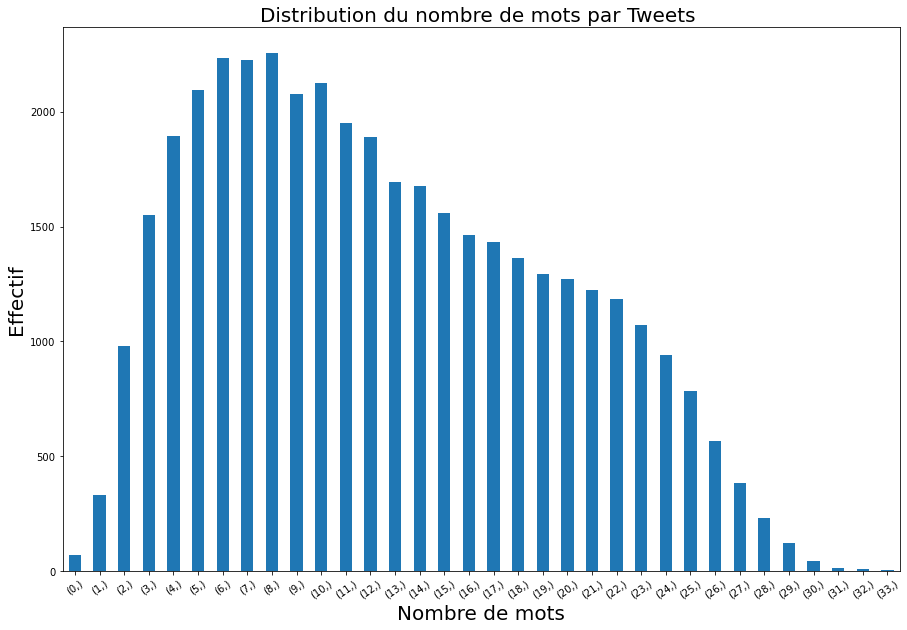

<IPython.core.display.Javascript object>

In [160]:
plt.figure(figsize=(15, 10))
tweets_length_sorted_df.plot.bar()
plt.xlabel("Nombre de mots", fontsize=20)
plt.xticks(rotation=35)
plt.ylabel("Effectif", fontsize=20)
plt.title("Distribution du nombre de mots par Tweets ", fontsize=20)
plt.show()

### <span style='color:#019DA0'>Synthèse :</span>
- Nous constatons qu'au delà de 27 mots, on a une fréquence de moins de 200 tweets par nombre de mots.
> Nous faisons le choix de retenir une **longeur maximale de 27 mots**

### <span style='color:#6A00B3'>Tokenization :</span>
- OOV : 'Out Of Vocabulary'. Le tokenizer va générer un token pour chaquer mot et remplacer chaque mot qu'il ne connait pas par le token 'OOV'
- word_to_index = dictionnaire mot - indice du mot

In [161]:
MAX_WORD_LENGTH = 27
oov_tk = "<OOV>"
trunc_type = "post"
padding_type = "post"

<IPython.core.display.Javascript object>

In [162]:
tokenizer = Tokenizer(oov_token=oov_tk)
tokenizer.fit_on_texts(X_train_sample)

word_to_index = tokenizer.word_index
vocabulary_size = len(word_to_index) + 1

print("Vocabulary size :", vocabulary_size)

Vocabulary size : 31834


<IPython.core.display.Javascript object>

##### Sauvegarde du Tokenizer pour être utilisé lors du déploiement sur Azure

In [163]:
tokenizer_json = tokenizer.to_json()
with io.open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

<IPython.core.display.Javascript object>

In [164]:
len(word_to_index)

31833

<IPython.core.display.Javascript object>

In [165]:
word_to_index

{'<OOV>': 1,
 'i': 2,
 'to': 3,
 'the': 4,
 'a': 5,
 'my': 6,
 'and': 7,
 'you': 8,
 'it': 9,
 'is': 10,
 'for': 11,
 'in': 12,
 'of': 13,
 'on': 14,
 'me': 15,
 'so': 16,
 'have': 17,
 'that': 18,
 'but': 19,
 "i'm": 20,
 'just': 21,
 'be': 22,
 'with': 23,
 'at': 24,
 'not': 25,
 'was': 26,
 'day': 27,
 'this': 28,
 'now': 29,
 'good': 30,
 'up': 31,
 'all': 32,
 'like': 33,
 'get': 34,
 'out': 35,
 'no': 36,
 'are': 37,
 'go': 38,
 'do': 39,
 'your': 40,
 'too': 41,
 'today': 42,
 "it's": 43,
 'work': 44,
 'quot': 45,
 'going': 46,
 'love': 47,
 'time': 48,
 'am': 49,
 'got': 50,
 'back': 51,
 'from': 52,
 'lol': 53,
 'what': 54,
 'we': 55,
 'u': 56,
 'one': 57,
 'will': 58,
 'really': 59,
 'know': 60,
 'about': 61,
 'had': 62,
 "don't": 63,
 'can': 64,
 'amp': 65,
 'im': 66,
 'some': 67,
 'see': 68,
 'well': 69,
 'its': 70,
 'if': 71,
 'night': 72,
 'new': 73,
 "can't": 74,
 'still': 75,
 'home': 76,
 'think': 77,
 'how': 78,
 'oh': 79,
 'thanks': 80,
 'as': 81,
 'want': 82,
 'morn

<IPython.core.display.Javascript object>

### <span style='color:#6A00B3'>Création de séquences:</span>
- On transforme les jeux de données en séquences
- Dans une séquence, chaque mot est remplacé par son indice dans le dictionnaire (Ex : 2 = i)

In [166]:
X_train_sample_sequences = tokenizer.texts_to_sequences(X_train_sample)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_app_sequences = tokenizer.texts_to_sequences(X_app)

<IPython.core.display.Javascript object>

In [167]:
X_train_sample

array(["Ahhhhhh someone help me get picked up from here! No one's picking up the phone",
       'just found out an old friend of mine passed away',
       "I love your show! I've subscribed and following your tweets. Can't wait to see more",
       ..., 'have you ever tried an Alesis Andromeda A6?',
       "Hi Mike! I would love for you to download my cd, &quot;bend&quot;, for $4 You'll luv it!",
       'I throw dinner parties like I have space for but comfortably can only fit .'],
      dtype=object)

<IPython.core.display.Javascript object>

In [168]:
X_train_sample_sequences

[[5070, 231, 241, 15, 34, 1511, 31, 52, 85, 36, 2423, 2807, 31, 4, 215],
 [21, 310, 35, 93, 238, 259, 13, 403, 918, 209],
 [2, 47, 40, 187, 140, 7031, 7, 409, 40, 428, 74, 139, 3, 68, 88],
 [2,
  12914,
  1225,
  5,
  1512,
  214,
  2,
  1226,
  77,
  2,
  58,
  29,
  842,
  23,
  32,
  4,
  278,
  23,
  181,
  485,
  46,
  14,
  343,
  194],
 [331,
  14,
  181,
  121,
  51,
  3,
  12915,
  457,
  117,
  58,
  1810,
  86,
  2988,
  2,
  102,
  59,
  1016,
  29],
 [12, 257, 461, 4, 1292, 10, 14, 4, 8931, 364, 2217, 8, 170, 388, 2, 58, 286],
 [2, 115, 2, 142, 38, 20, 487, 172, 208, 209],
 [15, 19, 2, 63, 299, 12, 673, 5],
 [152, 40, 2547, 12916, 30, 249, 46, 826, 1201],
 [21, 479, 250, 5, 986, 9, 1313, 528, 18, 135, 26, 25, 344, 24, 8932],
 [70, 111, 17, 16, 326, 12917, 12, 57, 27, 12918, 235, 70, 242],
 [28, 10, 2548, 21, 93, 2808, 194, 19, 2, 249, 505, 200, 1092, 12919, 29],
 [5870,
  78,
  39,
  2,
  2989,
  67,
  148,
  20,
  409,
  7,
  78,
  39,
  2,
  2313,
  32,
  380,
  1556,
  

<IPython.core.display.Javascript object>

##### Version sur tout le jeu d'entrainement et de test pour entrainement du modèle finale sur tout le jeu d'entrainement

In [169]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

<IPython.core.display.Javascript object>

##### Version avec tweets non préprocessés et light préprocessés pour comparaison des résulats

In [170]:
X_train_sample_notpreprocessed_sequences = tokenizer.texts_to_sequences(
    X_train_sample_notpreprocessed
)
X_val_notpreprocessed_sequences = tokenizer.texts_to_sequences(X_val_notpreprocessed)

<IPython.core.display.Javascript object>

In [171]:
X_train_sample_lightpreprocessed_sequences = tokenizer.texts_to_sequences(
    X_train_sample_lightpreprocessed
)
X_val_lightpreprocessed_sequences = tokenizer.texts_to_sequences(
    X_val_lightpreprocessed
)

<IPython.core.display.Javascript object>

### <span style='color:#6A00B3'>Nota Bene :</span>
Les séquences ont des dimensions différentes : dimension séquence = nombre de mots dans la séquence 

### <span style='color:#6A00B3'>Padding des séquences :</span>
- Le Padding est utilisé pour gérer des phrases (tweets dans notre cas) avec de longueurs différentes
- Les réseaux de neurones fonctionnent mieux avec des séquences de même dimension
- On va compléter les séquences pour qu'elles aient toutes la même dimension (dimension = max_word_length)

In [172]:
X_train_sample_pad = pad_sequences(
    X_train_sample_sequences,
    maxlen=MAX_WORD_LENGTH,
    padding=padding_type,
    truncating=trunc_type,
)
X_val_pad = pad_sequences(
    X_val_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type
)
X_app_pad = pad_sequences(
    X_app_sequences, maxlen=MAX_WORD_LENGTH, padding=padding_type, truncating=trunc_type
)

<IPython.core.display.Javascript object>

In [173]:
print("X_train_sample_pad Shape:", X_train_sample_pad.shape)
print("X_val_pad Shape:", X_val_pad.shape)
print("X_app_pad Shape:", X_app_pad.shape)

X_train_sample_pad Shape: (40000, 27)
X_val_pad Shape: (35000, 27)
X_app_pad Shape: (2000, 27)


<IPython.core.display.Javascript object>

In [174]:
X_train_sample_pad

array([[5070,  231,  241, ...,    0,    0,    0],
       [  21,  310,   35, ...,    0,    0,    0],
       [   2,   47,   40, ...,    0,    0,    0],
       ...,
       [  17,    8,  230, ...,    0,    0,    0],
       [ 282, 1966,    2, ...,    0,    0,    0],
       [   2, 1608,  362, ...,    0,    0,    0]], dtype=int32)

<IPython.core.display.Javascript object>

In [175]:
X_train_sample_pad[0]

array([5070,  231,  241,   15,   34, 1511,   31,   52,   85,   36, 2423,
       2807,   31,    4,  215,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

<IPython.core.display.Javascript object>

In [176]:
len(X_train_sample_pad[0])

27

<IPython.core.display.Javascript object>

In [177]:
X_train_sample_pad[1]

array([ 21, 310,  35,  93, 238, 259,  13, 403, 918, 209,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

<IPython.core.display.Javascript object>

In [178]:
len(X_train_sample_pad[1])

27

<IPython.core.display.Javascript object>

In [179]:
print("y_train_sample shape:", y_train_sample.shape)
print("y_val shape:", y_val.shape)
print("y_app shape:", y_app.shape)

y_train_sample shape: (40000,)
y_val shape: (35000,)
y_app shape: (2000,)


<IPython.core.display.Javascript object>

##### Version sur tout le jeu d'entrainement et de test pour entrainement du modèle finale sur tout le jeu d'entrainement

In [180]:
X_train_pad = pad_sequences(
    X_train_sequences,
    maxlen=MAX_WORD_LENGTH,
    padding=padding_type,
    truncating=trunc_type,
)
X_test_pad = pad_sequences(
    X_test_sequences,
    maxlen=MAX_WORD_LENGTH,
    padding=padding_type,
    truncating=trunc_type,
)

<IPython.core.display.Javascript object>

##### Version avec tweets non préprocessés et light préprocessés pour comparaison des résulats

In [181]:
X_train_sample_notpreprocessed_pad = pad_sequences(
    X_train_sample_notpreprocessed_sequences,
    maxlen=MAX_WORD_LENGTH,
    padding=padding_type,
    truncating=trunc_type,
)
X_val_notpreprocessed_pad = pad_sequences(
    X_val_notpreprocessed_sequences,
    maxlen=MAX_WORD_LENGTH,
    padding=padding_type,
    truncating=trunc_type,
)

<IPython.core.display.Javascript object>

In [182]:
X_train_sample_lightpreprocessed_pad = pad_sequences(
    X_train_sample_lightpreprocessed_sequences,
    maxlen=MAX_WORD_LENGTH,
    padding=padding_type,
    truncating=trunc_type,
)
X_val_lightpreprocessed_pad = pad_sequences(
    X_val_lightpreprocessed_sequences,
    maxlen=MAX_WORD_LENGTH,
    padding=padding_type,
    truncating=trunc_type,
)

<IPython.core.display.Javascript object>

### <span style='color:#6A00B3'>Fonction permettant de calculer le temps d'un modèle :</span>
- En plus de comparer l'Accuracy entre les différents modèles nous allons également calculer le **temps d'exécution** de chaque modèle afin de choisir le meilleur
- Pour cela nous utilisons la fonction 'Callback' ci-dessous

In [183]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

<IPython.core.display.Javascript object>

In [184]:
time_callback = TimeHistory()

<IPython.core.display.Javascript object>

In [185]:
# Hyper paramètres
NUM_EPOCHS = 7
BATCH_SIZE = 128
NUM_NEURONS = 50
EMBEDDING_DIMENSION = 300

<IPython.core.display.Javascript object>

>## <span style='color:green' id="section_4_3" >4.3. Modélisations utilisant différentes architectures de réseaux de neurones</span>

- Nous allons mettre en place et comparer les différentes architectures de modèles :
    - avec plongements de mots appris par le réseau
    - puis avec plongements de mots fournis au réseau

#### Fonction 'utiliataire' permettant d'afficher l'évolution de l'accuracy en fonction du nombre d'epochs

In [186]:
def plot_accuracy_loss(model_history):
    plt.figure()
    plt.plot(model_history.history["accuracy"])
    plt.plot(model_history.history["val_accuracy"])
    plt.legend(["Train", "Validation"])
    plt.title("Evolution de l'accuracy en fonction du nombre d'epochs")
    plt.show()

<IPython.core.display.Javascript object>

>>## <span style='color:#D15C22' id="section_4_3_1" >4.3.1 Words Embedding appris par le réseau</span>

### <span style='color:#6A00B3'>**1. Simple RNN (Recurrent Neural Networks) Model**</span>

In [187]:
simple_RNN_model = Sequential()
simple_RNN_model.add(
    Embedding(
        input_dim=vocabulary_size,
        output_dim=EMBEDDING_DIMENSION,
        input_length=MAX_WORD_LENGTH,
    )
)
simple_RNN_model.add(SimpleRNN(units=NUM_NEURONS))
simple_RNN_model.add(Dense(units=1, activation="sigmoid"))
simple_RNN_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 300)           9550200   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50)                17550     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 9,567,801
Trainable params: 9,567,801
Non-trainable params: 0
_________________________________________________________________


2022-06-30 21:12:00.229376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-30 21:12:00.259579: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994465000 Hz
2022-06-30 21:12:00.260668: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563dfdb2a990 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-30 21:12:00.260718: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-30 21:12:00.261974: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.

<IPython.core.display.Javascript object>

In [188]:
%%time
history_simple_RNN_model = simple_RNN_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

2022-06-30 21:12:00.429808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/7
313/313 [==============================] - 31s 93ms/step - loss: 0.6295 - accuracy: 0.6264 - val_loss: 0.5046 - val_accuracy: 0.7595
Epoch 2/7
313/313 [==============================] - 27s 87ms/step - loss: 0.3549 - accuracy: 0.8527 - val_loss: 0.5377 - val_accuracy: 0.7503
Epoch 3/7
313/313 [==============================] - 26s 85ms/step - loss: 0.1741 - accuracy: 0.9381 - val_loss: 0.6379 - val_accuracy: 0.7288
Epoch 4/7
313/313 [==============================] - 26s 84ms/step - loss: 0.0929 - accuracy: 0.9687 - val_loss: 0.7581 - val_accuracy: 0.7179
Epoch 5/7
313/313 [==============================] - 26s 84ms/step - loss: 0.0607 - accuracy: 0.9809 - val_loss: 0.8606 - val_accuracy: 0.7302
Epoch 6/7
313/313 [==============================] - 27s 85ms/step - loss: 0.0435 - accuracy: 0.9865 - val_loss: 0.9823 - val_accuracy: 0.7358
Epoch 7/7
313/313 [==============================] - 26s 85ms/step - loss: 0.0362 - accuracy: 0.9888 - val_loss: 1.0459 - val_accuracy: 0.7122

<IPython.core.display.Javascript object>

In [189]:
times_simple_RNN_model = time_callback.times

<IPython.core.display.Javascript object>

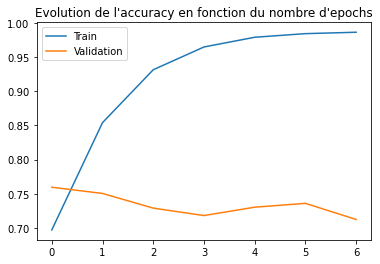

<IPython.core.display.Javascript object>

In [190]:
plot_accuracy_loss(history_simple_RNN_model)

### <span style='color:#6A00B3'>**2. Simple LSTM (Long Short Term Memory) Model**</span>

In [191]:
simple_LSTM_model = Sequential()
simple_LSTM_model.add(
    Embedding(
        input_dim=vocabulary_size,
        output_dim=EMBEDDING_DIMENSION,
        input_length=MAX_WORD_LENGTH,
    )
)
simple_LSTM_model.add(LSTM(units=NUM_NEURONS))
simple_LSTM_model.add(Dense(units=1, activation="sigmoid"))
simple_LSTM_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 27, 300)           9550200   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 9,620,451
Trainable params: 9,620,451
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [192]:
%%time
history_simple_LSTM_model = simple_LSTM_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/7
313/313 [==============================] - 37s 111ms/step - loss: 0.6088 - accuracy: 0.6298 - val_loss: 0.4771 - val_accuracy: 0.7749
Epoch 2/7
313/313 [==============================] - 34s 109ms/step - loss: 0.3711 - accuracy: 0.8415 - val_loss: 0.4895 - val_accuracy: 0.7693
Epoch 3/7
313/313 [==============================] - 35s 112ms/step - loss: 0.2674 - accuracy: 0.8922 - val_loss: 0.5247 - val_accuracy: 0.7607
Epoch 4/7
313/313 [==============================] - 35s 112ms/step - loss: 0.2089 - accuracy: 0.9159 - val_loss: 0.6460 - val_accuracy: 0.7570
Epoch 5/7
313/313 [==============================] - 34s 110ms/step - loss: 0.1625 - accuracy: 0.9340 - val_loss: 0.7153 - val_accuracy: 0.7502
Epoch 6/7
313/313 [==============================] - 34s 107ms/step - loss: 0.1230 - accuracy: 0.9495 - val_loss: 0.8658 - val_accuracy: 0.7520
Epoch 7/7
313/313 [==============================] - 35s 111ms/step - loss: 0.0980 - accuracy: 0.9619 - val_loss: 0.9360 - val_accuracy:

<IPython.core.display.Javascript object>

In [193]:
times_simple_LSTM_model = time_callback.times

<IPython.core.display.Javascript object>

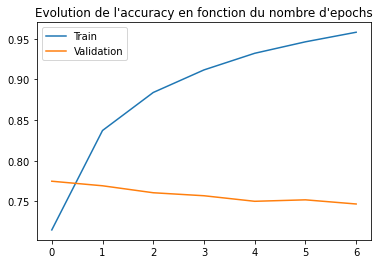

<IPython.core.display.Javascript object>

In [194]:
plot_accuracy_loss(history_simple_LSTM_model)

### <span style='color:#6A00B3'>**3. Simple GRU (Gated Recurrent Units) Model**</span>

In [195]:
simple_GRU_model = Sequential()
simple_GRU_model.add(
    Embedding(
        input_dim=vocabulary_size,
        output_dim=EMBEDDING_DIMENSION,
        input_length=MAX_WORD_LENGTH,
    )
)
simple_GRU_model.add(GRU(units=NUM_NEURONS))
simple_GRU_model.add(Dense(units=1, activation="sigmoid"))
simple_GRU_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_GRU_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 27, 300)           9550200   
_________________________________________________________________
gru (GRU)                    (None, 50)                52800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 9,603,051
Trainable params: 9,603,051
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [196]:
%%time
history_simple_GRU_model = simple_GRU_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/7
313/313 [==============================] - 38s 114ms/step - loss: 0.6643 - accuracy: 0.5453 - val_loss: 0.4833 - val_accuracy: 0.7696
Epoch 2/7
313/313 [==============================] - 35s 111ms/step - loss: 0.4029 - accuracy: 0.8229 - val_loss: 0.4756 - val_accuracy: 0.7770
Epoch 3/7
313/313 [==============================] - 34s 110ms/step - loss: 0.2846 - accuracy: 0.8886 - val_loss: 0.5188 - val_accuracy: 0.7646
Epoch 4/7
313/313 [==============================] - 34s 107ms/step - loss: 0.2060 - accuracy: 0.9205 - val_loss: 0.6108 - val_accuracy: 0.7542
Epoch 5/7
313/313 [==============================] - 34s 109ms/step - loss: 0.1566 - accuracy: 0.9424 - val_loss: 0.6939 - val_accuracy: 0.7487
Epoch 6/7
313/313 [==============================] - 34s 108ms/step - loss: 0.1165 - accuracy: 0.9564 - val_loss: 0.8284 - val_accuracy: 0.7411
Epoch 7/7
313/313 [==============================] - 34s 107ms/step - loss: 0.0964 - accuracy: 0.9630 - val_loss: 0.9032 - val_accuracy:

<IPython.core.display.Javascript object>

In [197]:
times_simple_GRU_model = time_callback.times

<IPython.core.display.Javascript object>

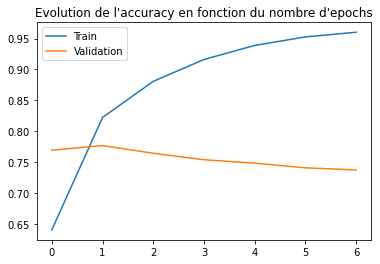

<IPython.core.display.Javascript object>

In [198]:
plot_accuracy_loss(history_simple_GRU_model)

### <span style='color:#6A00B3'>**4. Bidirectional LSTM Model**</span>

In [199]:
bidir_LSTM_model = Sequential()
bidir_LSTM_model.add(
    Embedding(
        input_dim=vocabulary_size,
        output_dim=EMBEDDING_DIMENSION,
        input_length=MAX_WORD_LENGTH,
    )
)
bidir_LSTM_model.add(Bidirectional(LSTM(units=NUM_NEURONS)))
bidir_LSTM_model.add(Dense(units=1, activation="sigmoid"))
bidir_LSTM_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
bidir_LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 27, 300)           9550200   
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               140400    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 9,690,701
Trainable params: 9,690,701
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [200]:
%%time
history_bidir_LSTM_model = bidir_LSTM_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/7
313/313 [==============================] - 50s 147ms/step - loss: 0.5865 - accuracy: 0.6686 - val_loss: 0.4732 - val_accuracy: 0.7757
Epoch 2/7
313/313 [==============================] - 46s 148ms/step - loss: 0.3591 - accuracy: 0.8452 - val_loss: 0.5001 - val_accuracy: 0.7699
Epoch 3/7
313/313 [==============================] - 46s 147ms/step - loss: 0.2539 - accuracy: 0.8968 - val_loss: 0.5448 - val_accuracy: 0.7636
Epoch 4/7
313/313 [==============================] - 47s 149ms/step - loss: 0.1842 - accuracy: 0.9249 - val_loss: 0.6147 - val_accuracy: 0.7573
Epoch 5/7
313/313 [==============================] - 47s 150ms/step - loss: 0.1411 - accuracy: 0.9453 - val_loss: 0.7878 - val_accuracy: 0.7522
Epoch 6/7
313/313 [==============================] - 47s 150ms/step - loss: 0.1061 - accuracy: 0.9587 - val_loss: 0.8362 - val_accuracy: 0.7512
Epoch 7/7
313/313 [==============================] - 47s 148ms/step - loss: 0.0863 - accuracy: 0.9660 - val_loss: 0.9581 - val_accuracy:

<IPython.core.display.Javascript object>

In [201]:
times_bidir_LSTM_model = time_callback.times

<IPython.core.display.Javascript object>

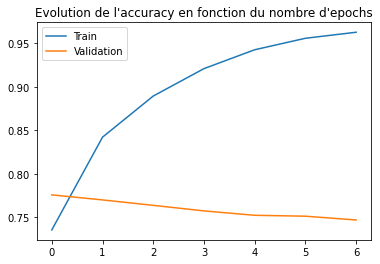

<IPython.core.display.Javascript object>

In [202]:
plot_accuracy_loss(history_bidir_LSTM_model)

##### Remarque :
- Tous les modèles sont en overfitting

>>## <span style='color:#D15C22' id="section_4_3_2" >4.3.2 Words Embedding fourni au réseau</span>

### <span style='color:#6A00B3'>**1. Simple RNN Model**</span>

In [203]:
simple_RNN_embed_model = Sequential()
simple_RNN_embed_model.add(
    Embedding(
        vocabulary_size,
        GLOVE_EMBEDDING_DIMENSION,
        weights=[glove_embedding_matrix],
        input_length=MAX_WORD_LENGTH,
        trainable=False,
    )
)
simple_RNN_embed_model.add(SimpleRNN(units=NUM_NEURONS))
simple_RNN_embed_model.add(Dense(units=1, activation="sigmoid"))
simple_RNN_embed_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_RNN_embed_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 27, 300)           9550200   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                17550     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 9,567,801
Trainable params: 17,601
Non-trainable params: 9,550,200
_________________________________________________________________


<IPython.core.display.Javascript object>

In [204]:
%%time
history_simple_RNN_embed_model = simple_RNN_embed_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/7
313/313 [==============================] - 10s 30ms/step - loss: 0.6486 - accuracy: 0.6028 - val_loss: 0.5574 - val_accuracy: 0.7195
Epoch 2/7
313/313 [==============================] - 8s 26ms/step - loss: 0.5411 - accuracy: 0.7294 - val_loss: 0.5424 - val_accuracy: 0.7284
Epoch 3/7
313/313 [==============================] - 8s 27ms/step - loss: 0.5275 - accuracy: 0.7437 - val_loss: 0.5440 - val_accuracy: 0.7312
Epoch 4/7
313/313 [==============================] - 8s 26ms/step - loss: 0.5130 - accuracy: 0.7502 - val_loss: 0.5470 - val_accuracy: 0.7199
Epoch 5/7
313/313 [==============================] - 8s 26ms/step - loss: 0.5018 - accuracy: 0.7578 - val_loss: 0.5348 - val_accuracy: 0.7330
Epoch 6/7
313/313 [==============================] - 8s 27ms/step - loss: 0.4852 - accuracy: 0.7676 - val_loss: 0.5374 - val_accuracy: 0.7372
Epoch 7/7
313/313 [==============================] - 8s 26ms/step - loss: 0.4754 - accuracy: 0.7751 - val_loss: 0.5440 - val_accuracy: 0.7295
CPU t

<IPython.core.display.Javascript object>

In [205]:
times_simple_RNN_embed_model = time_callback.times

<IPython.core.display.Javascript object>

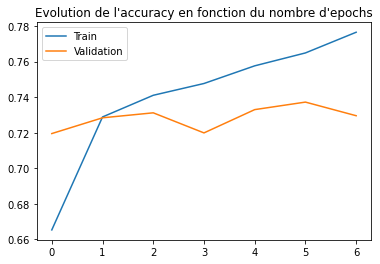

<IPython.core.display.Javascript object>

In [206]:
plot_accuracy_loss(history_simple_RNN_embed_model)

### <span style='color:#6A00B3'>**2. Simple LSTM (Long Short Term Memory) Model**</span>

In [207]:
simple_LSTM_embed_model = Sequential()
simple_LSTM_embed_model.add(
    Embedding(
        vocabulary_size,
        GLOVE_EMBEDDING_DIMENSION,
        weights=[glove_embedding_matrix],
        input_length=MAX_WORD_LENGTH,
        trainable=False,
    )
)
simple_LSTM_embed_model.add(LSTM(units=NUM_NEURONS))
simple_LSTM_embed_model.add(Dense(units=1, activation="sigmoid"))
simple_LSTM_embed_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_LSTM_embed_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 27, 300)           9550200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                70200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 9,620,451
Trainable params: 70,251
Non-trainable params: 9,550,200
_________________________________________________________________


<IPython.core.display.Javascript object>

In [208]:
%%time
history_simple_LSTM_embed_model = simple_LSTM_embed_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/7
313/313 [==============================] - 18s 50ms/step - loss: 0.6080 - accuracy: 0.6437 - val_loss: 0.5268 - val_accuracy: 0.7425
Epoch 2/7
313/313 [==============================] - 15s 49ms/step - loss: 0.4942 - accuracy: 0.7579 - val_loss: 0.4970 - val_accuracy: 0.7587
Epoch 3/7
313/313 [==============================] - 15s 47ms/step - loss: 0.4654 - accuracy: 0.7755 - val_loss: 0.4864 - val_accuracy: 0.7667
Epoch 4/7
313/313 [==============================] - 15s 47ms/step - loss: 0.4417 - accuracy: 0.7894 - val_loss: 0.4970 - val_accuracy: 0.7621
Epoch 5/7
313/313 [==============================] - 15s 48ms/step - loss: 0.4241 - accuracy: 0.8004 - val_loss: 0.4838 - val_accuracy: 0.7738
Epoch 6/7
313/313 [==============================] - 15s 47ms/step - loss: 0.4015 - accuracy: 0.8134 - val_loss: 0.5091 - val_accuracy: 0.7719
Epoch 7/7
313/313 [==============================] - 15s 48ms/step - loss: 0.3824 - accuracy: 0.8267 - val_loss: 0.5076 - val_accuracy: 0.7728

<IPython.core.display.Javascript object>

In [209]:
times_simple_LSTM_embed_model = time_callback.times

<IPython.core.display.Javascript object>

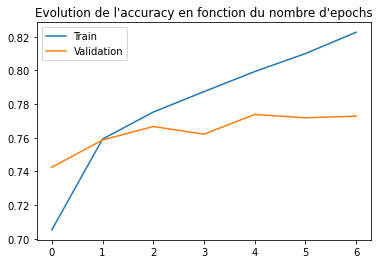

<IPython.core.display.Javascript object>

In [210]:
plot_accuracy_loss(history_simple_LSTM_embed_model)

### <span style='color:#6A00B3'>**3. Simple GRU (Gated Recurrent Units) Model**</span>

In [211]:
simple_GRU_embed_model = Sequential()
simple_GRU_embed_model.add(
    Embedding(
        vocabulary_size,
        GLOVE_EMBEDDING_DIMENSION,
        weights=[glove_embedding_matrix],
        input_length=MAX_WORD_LENGTH,
        trainable=False,
    )
)
simple_GRU_embed_model.add(GRU(units=NUM_NEURONS))
simple_GRU_embed_model.add(Dense(units=1, activation="sigmoid"))
simple_GRU_embed_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_GRU_embed_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 27, 300)           9550200   
_________________________________________________________________
gru_1 (GRU)                  (None, 50)                52800     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 9,603,051
Trainable params: 52,851
Non-trainable params: 9,550,200
_________________________________________________________________


<IPython.core.display.Javascript object>

In [212]:
%%time
history_simple_GRU_embed_model = simple_GRU_embed_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/7
313/313 [==============================] - 20s 55ms/step - loss: 0.6449 - accuracy: 0.5863 - val_loss: 0.5193 - val_accuracy: 0.7466
Epoch 2/7
313/313 [==============================] - 16s 50ms/step - loss: 0.4924 - accuracy: 0.7607 - val_loss: 0.4915 - val_accuracy: 0.7624
Epoch 3/7
313/313 [==============================] - 15s 48ms/step - loss: 0.4638 - accuracy: 0.7800 - val_loss: 0.4810 - val_accuracy: 0.7685
Epoch 4/7
313/313 [==============================] - 15s 47ms/step - loss: 0.4424 - accuracy: 0.7926 - val_loss: 0.4811 - val_accuracy: 0.7731
Epoch 5/7
313/313 [==============================] - 15s 48ms/step - loss: 0.4266 - accuracy: 0.8027 - val_loss: 0.4819 - val_accuracy: 0.7733
Epoch 6/7
313/313 [==============================] - 15s 48ms/step - loss: 0.4106 - accuracy: 0.8112 - val_loss: 0.4941 - val_accuracy: 0.7754
Epoch 7/7
313/313 [==============================] - 15s 48ms/step - loss: 0.3881 - accuracy: 0.8249 - val_loss: 0.5060 - val_accuracy: 0.7729

<IPython.core.display.Javascript object>

In [213]:
times_simple_GRU_embed_model = time_callback.times

<IPython.core.display.Javascript object>

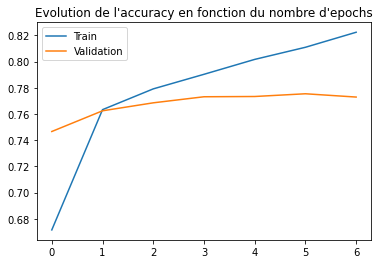

<IPython.core.display.Javascript object>

In [214]:
plot_accuracy_loss(history_simple_GRU_embed_model)

### <span style='color:#6A00B3'>**4. Bidirectional LSTM Model**</span>

In [215]:
bidir_LSTM_embed_model = Sequential()
bidir_LSTM_embed_model.add(
    Embedding(
        vocabulary_size,
        GLOVE_EMBEDDING_DIMENSION,
        weights=[glove_embedding_matrix],
        input_length=MAX_WORD_LENGTH,
        trainable=False,
    )
)
bidir_LSTM_embed_model.add(Bidirectional(LSTM(units=NUM_NEURONS)))
bidir_LSTM_embed_model.add(Dense(units=1, activation="sigmoid"))
bidir_LSTM_embed_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
bidir_LSTM_embed_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 27, 300)           9550200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 9,690,701
Trainable params: 140,501
Non-trainable params: 9,550,200
_________________________________________________________________


<IPython.core.display.Javascript object>

In [216]:
%%time
history_bidir_LSTM_embed_model = bidir_LSTM_embed_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val), callbacks=time_callback)

Epoch 1/7
313/313 [==============================] - 31s 86ms/step - loss: 0.5966 - accuracy: 0.6657 - val_loss: 0.5177 - val_accuracy: 0.7453
Epoch 2/7
313/313 [==============================] - 26s 83ms/step - loss: 0.4864 - accuracy: 0.7615 - val_loss: 0.4918 - val_accuracy: 0.7612
Epoch 3/7
313/313 [==============================] - 27s 85ms/step - loss: 0.4578 - accuracy: 0.7829 - val_loss: 0.4918 - val_accuracy: 0.7610
Epoch 4/7
313/313 [==============================] - 26s 84ms/step - loss: 0.4284 - accuracy: 0.7976 - val_loss: 0.4809 - val_accuracy: 0.7704
Epoch 5/7
313/313 [==============================] - 26s 84ms/step - loss: 0.4011 - accuracy: 0.8165 - val_loss: 0.4779 - val_accuracy: 0.7721
Epoch 6/7
313/313 [==============================] - 26s 84ms/step - loss: 0.3670 - accuracy: 0.8333 - val_loss: 0.5136 - val_accuracy: 0.7705
Epoch 7/7
313/313 [==============================] - 26s 84ms/step - loss: 0.3373 - accuracy: 0.8541 - val_loss: 0.5147 - val_accuracy: 0.7699

<IPython.core.display.Javascript object>

In [217]:
times_bidir_LSTM_embed_model = time_callback.times

<IPython.core.display.Javascript object>

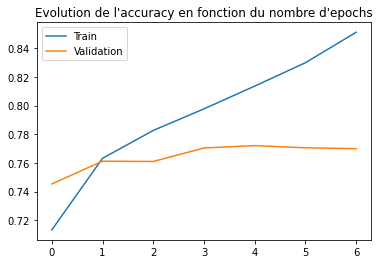

<IPython.core.display.Javascript object>

In [218]:
plot_accuracy_loss(history_bidir_LSTM_embed_model)

##### Remarques :
- Les résultats en terme d'Accuracy sont légèrement meilleurs pour les modèles avec couche d'embedding fournie au réseau
- Les modèles avec couche d'embedding fournie au réseau permettent de réduire nettement l'overfitting

>## <span style='color:green' id="section_4_4" >4.4. Comparaison des modèles et sélection du meilleur modèle</span>

- Nous comparons :
    - l'Accuracy
    - le temps d'exécution

In [219]:
name_history_models = [
    "simple_RNN_model",
    "simple_LSTM_model",
    "simple_GRU_model",
    "bidir_LSTM_model",
]
list_history_models = [
    history_simple_RNN_model,
    history_simple_LSTM_model,
    history_simple_GRU_model,
    history_bidir_LSTM_model,
]
list_times_models = [
    times_simple_RNN_model,
    times_simple_LSTM_model,
    times_simple_GRU_model,
    times_bidir_LSTM_model,
]

name_history_embed_models = [
    "simple_RNN_embed_model",
    "simple_LSTM_embed_model",
    "simple_GRU_embed_model",
    "bidir_LSTM_embed_model",
]
list_history_embed_models = [
    history_simple_RNN_embed_model,
    history_simple_LSTM_embed_model,
    history_simple_GRU_embed_model,
    history_bidir_LSTM_embed_model,
]
list_times_embed_models = [
    times_simple_RNN_embed_model,
    times_simple_LSTM_embed_model,
    times_simple_GRU_embed_model,
    times_bidir_LSTM_embed_model,
]

<IPython.core.display.Javascript object>

#### <span style='color:#6A00B3'>Comparaison des scores d'Accuracy et des temps d'exécution pour les modèles dont les words embeddings sont appris par les réseaux</span>

In [220]:
best_accuracy_per_model = {}
time_per_model = {}
for i, model_history in enumerate(list_history_models):
    best_accuracy_per_model[name_history_models[i]] = max(
        model_history.history["val_accuracy"]
    )
    time_per_model[name_history_models[i]] = list_times_models[i][
        np.argmax(model_history.history["val_accuracy"])
    ]

<IPython.core.display.Javascript object>

In [221]:
best_accuracy_per_model_sorted = dict(
    sorted(best_accuracy_per_model.items(), key=lambda item: item[1], reverse=True)
)

<IPython.core.display.Javascript object>

In [222]:
best_accuracy_per_model_sorted

{'simple_GRU_model': 0.7770000100135803,
 'bidir_LSTM_model': 0.775685727596283,
 'simple_LSTM_model': 0.7748571634292603,
 'simple_RNN_model': 0.7594571709632874}

<IPython.core.display.Javascript object>

In [336]:
# function to add value labels
def addlabels(x, y):
    for i in range(len(x)):
        plt.text(i, round(y[i], 3), round(y[i], 3), ha="center", fontsize=14)

<IPython.core.display.Javascript object>

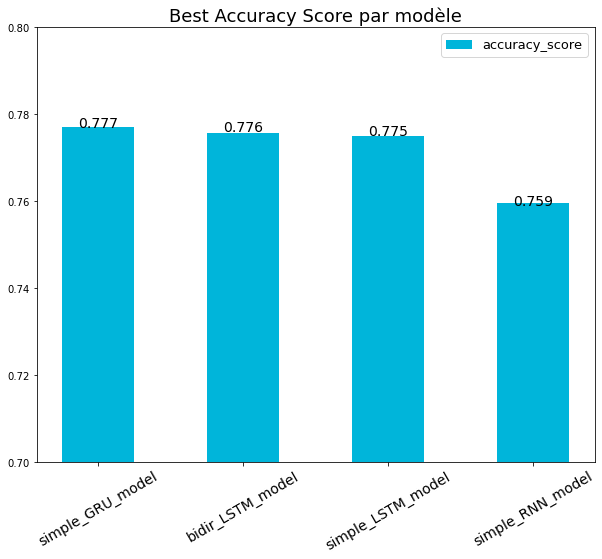

<IPython.core.display.Javascript object>

In [337]:
width = 0.5
ind = np.arange(len(best_accuracy_per_model_sorted.items()))

plt.figure(figsize=(10, 8))
plt.bar(
    ind,
    best_accuracy_per_model_sorted.values(),
    width,
    color="#00B5DA",
    label="accuracy_score",
)
addlabels(ind, list(best_accuracy_per_model_sorted.values()))
plt.xticks(
    range(len(best_accuracy_per_model_sorted.items())),
    best_accuracy_per_model_sorted.keys(),
    fontsize=14,
    rotation=30,
)
plt.ylim(0.7, 0.8)
plt.legend(fontsize=13)
plt.title("Best Accuracy Score par modèle", fontsize=18)
plt.show()

In [224]:
time_per_model_sorted = dict(sorted(time_per_model.items(), key=lambda item: item[1]))

<IPython.core.display.Javascript object>

In [225]:
time_per_model_sorted

{'simple_RNN_model': 30.645023584365845,
 'simple_GRU_model': 34.79174494743347,
 'simple_LSTM_model': 37.23542928695679,
 'bidir_LSTM_model': 50.061458110809326}

<IPython.core.display.Javascript object>

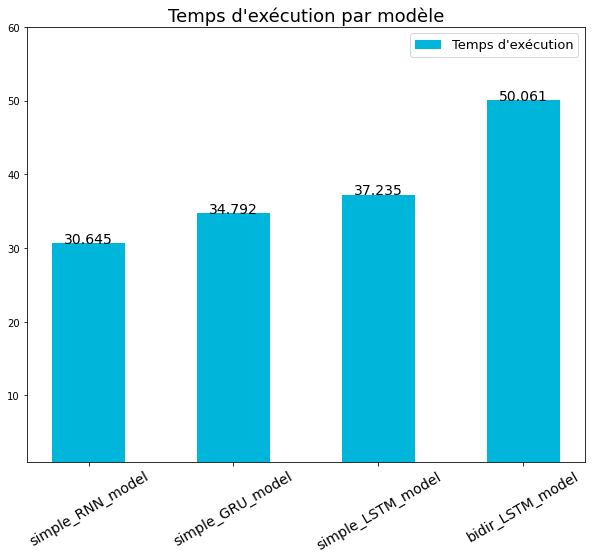

<IPython.core.display.Javascript object>

In [338]:
width = 0.5
ind = np.arange(len(time_per_model_sorted.items()))

plt.figure(figsize=(10, 8))
plt.bar(
    ind,
    time_per_model_sorted.values(),
    width,
    color="#00B5DA",
    label="Temps d'exécution",
)
addlabels(ind, list(time_per_model_sorted.values()))
plt.xticks(
    range(len(time_per_model_sorted.items())),
    time_per_model_sorted.keys(),
    fontsize=14,
    rotation=30,
)
plt.ylim(1, 60)
plt.legend(fontsize=13)
plt.title("Temps d'exécution par modèle", fontsize=18)
plt.show()

#### <span style='color:#6A00B3'>Comparaison des scores d'Accuracy et des temps d'exécution pour les modèles dont les words embeddings sont fournis aux réseaux</span>

In [227]:
best_accuracy_per_embed_model = {}
time_per_embed_model = {}
for i, model_history in enumerate(list_history_embed_models):
    best_accuracy_per_embed_model[name_history_embed_models[i]] = max(
        model_history.history["val_accuracy"]
    )
    time_per_embed_model[name_history_embed_models[i]] = list_times_embed_models[i][
        np.argmax(model_history.history["val_accuracy"])
    ]

<IPython.core.display.Javascript object>

In [228]:
best_accuracy_per_embed_model_sorted = dict(
    sorted(
        best_accuracy_per_embed_model.items(), key=lambda item: item[1], reverse=True
    )
)

<IPython.core.display.Javascript object>

In [229]:
best_accuracy_per_embed_model_sorted

{'simple_GRU_embed_model': 0.7753999829292297,
 'simple_LSTM_embed_model': 0.7738285660743713,
 'bidir_LSTM_embed_model': 0.7720857262611389,
 'simple_RNN_embed_model': 0.7372000217437744}

<IPython.core.display.Javascript object>

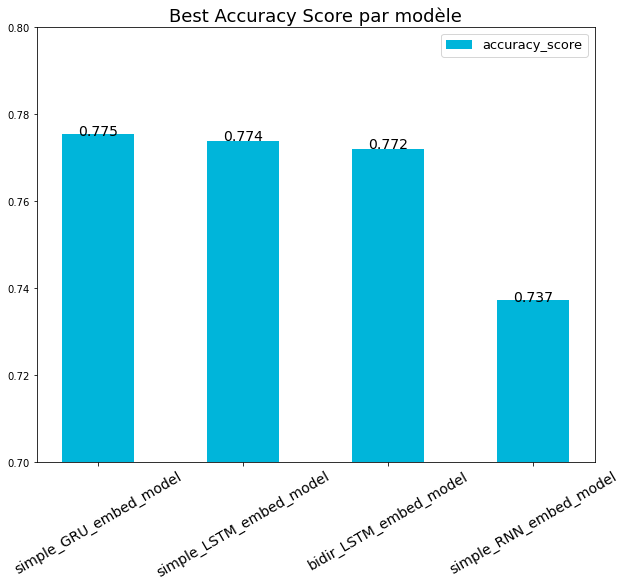

<IPython.core.display.Javascript object>

In [339]:
width = 0.5
ind = np.arange(len(best_accuracy_per_embed_model_sorted.items()))

plt.figure(figsize=(10, 8))
plt.bar(
    ind,
    best_accuracy_per_embed_model_sorted.values(),
    width,
    color="#00B5DA",
    label="accuracy_score",
)
addlabels(ind, list(best_accuracy_per_embed_model_sorted.values()))
plt.xticks(
    range(len(best_accuracy_per_embed_model_sorted.items())),
    best_accuracy_per_embed_model_sorted.keys(),
    fontsize=14,
    rotation=30,
)
plt.ylim(0.7, 0.8)
plt.legend(fontsize=13)
plt.title("Best Accuracy Score par modèle", fontsize=18)
plt.show()

In [330]:
time_per_embed_model_sorted = dict(
    sorted(time_per_embed_model.items(), key=lambda item: item[1])
)

<IPython.core.display.Javascript object>

In [331]:
time_per_embed_model_sorted

{'simple_RNN_embed_model': 8.431564092636108,
 'simple_LSTM_embed_model': 15.112440824508667,
 'simple_GRU_embed_model': 15.131345272064209,
 'bidir_LSTM_embed_model': 26.16947293281555}

<IPython.core.display.Javascript object>

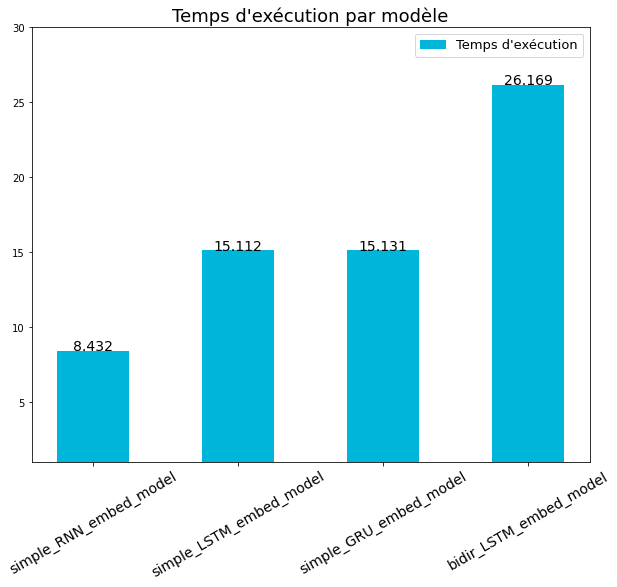

<IPython.core.display.Javascript object>

In [340]:
width = 0.5
ind = np.arange(len(time_per_embed_model_sorted.items()))

plt.figure(figsize=(10, 8))
plt.bar(
    ind,
    time_per_embed_model_sorted.values(),
    width,
    color="#00B5DA",
    label="Temps d'exécution",
)
addlabels(ind, list(time_per_embed_model_sorted.values()))
plt.xticks(
    range(len(time_per_embed_model_sorted.items())),
    time_per_embed_model_sorted.keys(),
    fontsize=14,
    rotation=30,
)
plt.ylim(1, 30)
plt.legend(fontsize=13)
plt.title("Temps d'exécution par modèle", fontsize=18)
plt.show()

### <span style='color:#019DA0'>Synthèse et choix du meilleur modèle :</span>
- Les modèles avec la couche 'words embedding' fournie au réseau présente des résultats meilleurs que ceux dont la couche de 'words embedding' est apprise par le réseau :
    - l'accuracy est à peu près le même, 
    - ils sont beaucoup plus rapides en terme de temps d'éxécution,
    - ils présentent beaucoup moins d'overfitting, 
- Parmi ces modèles, c'est le modèle 'simple GRU' qui donne le meilleur résultat en terme d'accuracy
- Le modèle 'simple GRU' est également un peu plus rapide en temps d'exécution comparé au model 'simple LSTM'.
> Le meilleur modèle que nous retenons est le modèle **simple GRU avec couche de plongement de mots fournie au réseau**

>## <span style='color:green' id="section_4_5" >4.5. Optimisation du meilleur modèle</span>
- Nous allons optimiser :
    - la couche de 'words embedding' utilisée en essayant une autre méthode de plongement de mots :
        - un plongement FastText entrainé sur les Tweets du jeu d'entrainement
    - les hyper paramètres du modèle avec Keras Tuner :
        - optimisation des Dropout
        - optimisation du Learning Rate

>>## <span style='color:#D15C22' id="section_4_5_1" >4.5.1 Optimisation du plongement de mots utilisé</span>

### <span style='color:#6A00B3'>Modèle FastText appris sur les Tweets du jeu d'entrainement</span>

#### Construction de la liste des tweets

In [234]:
tweets_list = [tweet.split() for tweet in tweets]

<IPython.core.display.Javascript object>

#### Entrainement du modèle

In [235]:
fasttext_trained_model = FastText(vector_size=10, window=3, min_count=1)

<IPython.core.display.Javascript object>

In [236]:
fasttext_trained_model.build_vocab(corpus_iterable=tweets_list)

<IPython.core.display.Javascript object>

In [237]:
fasttext_trained_model.train(
    corpus_iterable=tweets_list, total_examples=len(tweets_list), epochs=7
)

(2928019, 3520895)

<IPython.core.display.Javascript object>

#### Test du modèle

In [238]:
fasttext_trained_model.wv["good"]

array([-1.4993333, -1.595554 ,  2.1999435,  1.4893285,  4.0624704,
        3.0334144,  5.025323 ,  2.5264444, -3.947689 ,  1.7939065],
      dtype=float32)

<IPython.core.display.Javascript object>

#### Création de la matrice embedding FastText
- Matrice contenant pour chaque mot du vocabulaire le vecteur embedding correspondant
- Taille de la matrice = nombre mots dans le vocabulaire * taille des vecteurs embeddings

In [239]:
FASTTEXT_EMBEDDING_DIMENSION = 10

fasttext_embedding_matrix = np.zeros((vocabulary_size, FASTTEXT_EMBEDDING_DIMENSION))

for word, i in word_to_index.items():
    fasttext_embedding_matrix[i] = fasttext_trained_model.wv[word]

<IPython.core.display.Javascript object>

#### Taille de la matrice embedding

In [240]:
fasttext_embedding_matrix.shape

(31834, 10)

<IPython.core.display.Javascript object>

In [241]:
fasttext_embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.12901305e-02,  1.09792305e-02,  2.08261665e-02, ...,
         2.15062182e-02, -2.01428793e-02,  1.11180749e-02],
       [ 2.14025903e+00, -3.24936390e+00,  1.32663841e+01, ...,
         1.74540639e+00, -4.73660946e+00, -5.87513924e+00],
       ...,
       [ 5.20243347e-01,  5.21989882e-01,  6.25737965e-01, ...,
         1.23666561e+00, -7.49247491e-01,  1.92500681e-01],
       [ 3.27011198e-03, -3.40242796e-02,  6.21127076e-02, ...,
         3.01804487e-02,  4.22306806e-02, -5.12650795e-02],
       [ 6.25384688e-01, -2.25854535e-02,  8.11599076e-01, ...,
         1.40485859e+00, -3.94545674e-01,  3.26067694e-02]])

<IPython.core.display.Javascript object>

In [242]:
simple_GRU_fasttext_model = Sequential()
simple_GRU_fasttext_model.add(
    Embedding(
        vocabulary_size,
        FASTTEXT_EMBEDDING_DIMENSION,
        weights=[fasttext_embedding_matrix],
        input_length=MAX_WORD_LENGTH,
        trainable=False,
    )
)
simple_GRU_fasttext_model.add(GRU(units=NUM_NEURONS))
simple_GRU_fasttext_model.add(Dense(units=1, activation="sigmoid"))
simple_GRU_fasttext_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_GRU_fasttext_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 27, 10)            318340    
_________________________________________________________________
gru_2 (GRU)                  (None, 50)                9300      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 327,691
Trainable params: 9,351
Non-trainable params: 318,340
_________________________________________________________________


<IPython.core.display.Javascript object>

In [243]:
%%time
history_simple_GRU_fasttext_model = simple_GRU_fasttext_model.fit(X_train_pad, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val))

Epoch 1/7
644/644 [==============================] - 27s 38ms/step - loss: 0.6720 - accuracy: 0.5564 - val_loss: 0.6085 - val_accuracy: 0.6637
Epoch 2/7
644/644 [==============================] - 24s 36ms/step - loss: 0.5882 - accuracy: 0.6850 - val_loss: 0.5873 - val_accuracy: 0.6849
Epoch 3/7
644/644 [==============================] - 23s 35ms/step - loss: 0.5685 - accuracy: 0.6995 - val_loss: 0.5652 - val_accuracy: 0.7047
Epoch 4/7
644/644 [==============================] - 23s 35ms/step - loss: 0.5548 - accuracy: 0.7103 - val_loss: 0.5638 - val_accuracy: 0.7092
Epoch 5/7
644/644 [==============================] - 24s 37ms/step - loss: 0.5453 - accuracy: 0.7193 - val_loss: 0.5528 - val_accuracy: 0.7151
Epoch 6/7
644/644 [==============================] - 23s 36ms/step - loss: 0.5390 - accuracy: 0.7231 - val_loss: 0.5486 - val_accuracy: 0.7174
Epoch 7/7
644/644 [==============================] - 24s 37ms/step - loss: 0.5355 - accuracy: 0.7276 - val_loss: 0.5447 - val_accuracy: 0.7201

<IPython.core.display.Javascript object>

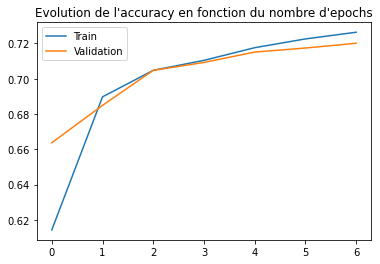

<IPython.core.display.Javascript object>

In [244]:
plot_accuracy_loss(history_simple_GRU_fasttext_model)

### <span style='color:#019DA0'>Synthèse :</span>
- Les résultats sont moins bons avec ce modèle comparé au modèle GloVe :
    - l'accuracy est moins élevée (meilleure accuracy = 0.72 vs 0.775 pour le modèle GloVe classique),
    - le temps d'exécution de l'entrainement est plus long (environ 3 minutes vs moins de 1min 50s pour le modèle GloVe),
- Il n'y a en revanche pratiquement pas d'overfitting.

### <span style='color:#6A00B3'>Modèle préentrainé sur des Tweets : GloVe Twitter</span>

#### Chargement du modèle : GloVe word embedding Tweeter 27-billion and 100-dimensional text
- Construction du dictionnaire contenant chaque mot (clé) et son vector embedding (valeur)
- Taille des vecteurs GloVe Twitter = 100

In [245]:
glove_tweeter_embeddings_index = {}

with open(path_dataset + "glove.twitter.27B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        glove_tweeter_embeddings_index[word] = coefs
    f.close()

print("Found %s word vectors." % len(glove_tweeter_embeddings_index))

Found 1193514 word vectors.


<IPython.core.display.Javascript object>

#### Taille du dictionnaire du modèle GloVe

In [246]:
len(glove_tweeter_embeddings_index)

1193514

<IPython.core.display.Javascript object>

#### Taille des vecteurs de mots du modèle GloVe

In [247]:
len(glove_tweeter_embeddings_index["good"])

100

<IPython.core.display.Javascript object>

#### Exemple de vecteur de mot

In [248]:
glove_tweeter_embeddings_index["good"]

array([ 9.1552e-02,  9.3336e-02, -2.8113e-02,  3.6990e-01,  1.8956e-01,
        4.3191e-01,  1.0266e-01,  3.4092e-01, -3.8717e-01,  5.0772e-02,
       -4.8289e-01, -3.7883e-01, -5.0020e+00, -2.7927e-01, -1.4578e-01,
       -1.0818e-01,  3.9178e-01, -4.5798e-01, -5.4712e-01, -2.0868e-01,
       -3.3495e-02,  1.0765e-01, -1.7093e-01, -1.0107e-01,  1.1071e-01,
       -1.7558e-01, -3.5739e-01,  1.5897e-01,  7.9770e-02, -9.7594e-01,
       -3.9054e-01,  1.5097e-01, -5.6339e-01,  5.0047e-01,  1.7436e-01,
        6.8966e-01,  2.6879e-01, -4.7430e-01, -1.4947e-02,  2.3483e-01,
       -9.4609e-01, -5.5384e-02,  2.7673e-01,  4.1185e-01,  3.5373e-01,
        3.6709e-01, -1.4923e-01, -6.6414e-02,  2.5766e-01, -3.6882e-03,
       -6.6522e-01,  7.5965e-02, -3.0112e-01, -1.5115e-01,  3.5540e-01,
        5.9782e-01, -2.0585e-01, -4.8643e-01,  6.6179e-01, -1.3902e-01,
        2.4042e-02, -9.1297e-01, -2.1795e-01,  4.9977e-01,  4.9224e-02,
       -4.8337e-01, -5.1529e-01, -6.8428e-01, -2.4887e-01,  5.98

<IPython.core.display.Javascript object>

#### Création de la matrice embedding GloVe Tweeter
- Matrice contenant pour chaque mot du vocabulaire (word_to_index.items()) le vecteur embedding correspondant
- Taille de la matrice = nombre mots dans le vocabulaire * taille des vecteurs embeddings

In [249]:
GLOVE_TWEETER_EMBEDDING_DIMENSION = 100

glove_tweeter_embedding_matrix = np.zeros(
    (vocabulary_size, GLOVE_TWEETER_EMBEDDING_DIMENSION)
)

for word, i in word_to_index.items():
    embedding_vector = glove_tweeter_embeddings_index.get(word)
    if embedding_vector is not None:
        glove_tweeter_embedding_matrix[i] = embedding_vector

<IPython.core.display.Javascript object>

#### Taille de la matrice embedding

In [250]:
glove_tweeter_embedding_matrix.shape

(31834, 100)

<IPython.core.display.Javascript object>

In [251]:
glove_tweeter_embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.96210002e-04,  4.56699997e-01,  3.38900000e-01, ...,
        -4.29100007e-01,  1.07459998e+00, -3.65500003e-01],
       ...,
       [ 9.47669968e-02, -6.71450019e-01, -1.81160003e-01, ...,
        -7.22249985e-01, -1.66069999e-01,  7.91869998e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.68279982e-01,  1.52909994e-01,  7.04050004e-01, ...,
         3.63420010e-01, -5.23840010e-01, -3.90480012e-01]])

<IPython.core.display.Javascript object>

#### Test de la matrice embedding

In [252]:
word_to_index["good"]

30

<IPython.core.display.Javascript object>

In [253]:
glove_tweeter_embeddings_index.get("good")

array([ 9.1552e-02,  9.3336e-02, -2.8113e-02,  3.6990e-01,  1.8956e-01,
        4.3191e-01,  1.0266e-01,  3.4092e-01, -3.8717e-01,  5.0772e-02,
       -4.8289e-01, -3.7883e-01, -5.0020e+00, -2.7927e-01, -1.4578e-01,
       -1.0818e-01,  3.9178e-01, -4.5798e-01, -5.4712e-01, -2.0868e-01,
       -3.3495e-02,  1.0765e-01, -1.7093e-01, -1.0107e-01,  1.1071e-01,
       -1.7558e-01, -3.5739e-01,  1.5897e-01,  7.9770e-02, -9.7594e-01,
       -3.9054e-01,  1.5097e-01, -5.6339e-01,  5.0047e-01,  1.7436e-01,
        6.8966e-01,  2.6879e-01, -4.7430e-01, -1.4947e-02,  2.3483e-01,
       -9.4609e-01, -5.5384e-02,  2.7673e-01,  4.1185e-01,  3.5373e-01,
        3.6709e-01, -1.4923e-01, -6.6414e-02,  2.5766e-01, -3.6882e-03,
       -6.6522e-01,  7.5965e-02, -3.0112e-01, -1.5115e-01,  3.5540e-01,
        5.9782e-01, -2.0585e-01, -4.8643e-01,  6.6179e-01, -1.3902e-01,
        2.4042e-02, -9.1297e-01, -2.1795e-01,  4.9977e-01,  4.9224e-02,
       -4.8337e-01, -5.1529e-01, -6.8428e-01, -2.4887e-01,  5.98

<IPython.core.display.Javascript object>

In [254]:
simple_GRU_glovetweeter_model = Sequential()
simple_GRU_glovetweeter_model.add(
    Embedding(
        vocabulary_size,
        GLOVE_TWEETER_EMBEDDING_DIMENSION,
        weights=[glove_tweeter_embedding_matrix],
        input_length=MAX_WORD_LENGTH,
        trainable=False,
    )
)
simple_GRU_glovetweeter_model.add(GRU(units=NUM_NEURONS))
simple_GRU_glovetweeter_model.add(Dense(units=1, activation="sigmoid"))
simple_GRU_glovetweeter_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_GRU_glovetweeter_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 27, 100)           3183400   
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 3,206,251
Trainable params: 22,851
Non-trainable params: 3,183,400
_________________________________________________________________


<IPython.core.display.Javascript object>

In [255]:
%%time
history_simple_GRU_glovetweeter_model = simple_GRU_glovetweeter_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val))

Epoch 1/7
313/313 [==============================] - 17s 46ms/step - loss: 0.6346 - accuracy: 0.6018 - val_loss: 0.5068 - val_accuracy: 0.7574
Epoch 2/7
313/313 [==============================] - 14s 46ms/step - loss: 0.4780 - accuracy: 0.7697 - val_loss: 0.4781 - val_accuracy: 0.7712
Epoch 3/7
313/313 [==============================] - 14s 45ms/step - loss: 0.4547 - accuracy: 0.7866 - val_loss: 0.4685 - val_accuracy: 0.7765
Epoch 4/7
313/313 [==============================] - 14s 44ms/step - loss: 0.4429 - accuracy: 0.7909 - val_loss: 0.4649 - val_accuracy: 0.7804
Epoch 5/7
313/313 [==============================] - 13s 43ms/step - loss: 0.4345 - accuracy: 0.7982 - val_loss: 0.4660 - val_accuracy: 0.7813
Epoch 6/7
313/313 [==============================] - 14s 43ms/step - loss: 0.4228 - accuracy: 0.8026 - val_loss: 0.4703 - val_accuracy: 0.7830
Epoch 7/7
313/313 [==============================] - 14s 44ms/step - loss: 0.4067 - accuracy: 0.8145 - val_loss: 0.4624 - val_accuracy: 0.7827

<IPython.core.display.Javascript object>

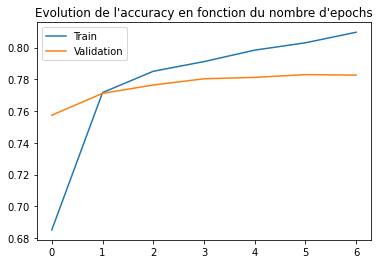

<IPython.core.display.Javascript object>

In [256]:
plot_accuracy_loss(history_simple_GRU_glovetweeter_model)

### <span style='color:#019DA0'>Synthèse :</span>

- Les résulats sont meilleurs avec ce plongement de mots GloVe entrainé sur des Tweets comparé au plongement de mots GloVe 'classique' :
    - L'accuracy est légèrement plus élevée (meilleure accuracy = 0.783 vs 0.777 pour le modèle GloVe classique)
    - Le temps d'exécution est plus faible (1min 38s vs 1min 55s pour le modèle GloVe classique)
    - L'overfitting a diminué
> Nous sélectionnons donc ce plongement de mots comme couche d'embedding et nous allons optimiser les hyper paramètres du meilleur modèle : **simple GRU avec couche de plongement de mots fournie au réseau de type GloVe préentrainé sur des Tweets**

>>## <span style='color:#D15C22' id="section_4_5_2" >4.5.2 Optimisation des hyperparamètres avec KerasTuner</span>

#### Paramètres à optimiser :
- Pourcentage de Dropout : nous avons ajouté 2 couches de type Dropout pour diminuer l'overfitting
- Vitesse d'apprentissage (Learning Rate)                          

In [257]:
def build_simple_GRU_glovetweeter_optim_model(hp):

    simple_GRU_glovetweeter_optim_model = Sequential()

    simple_GRU_glovetweeter_optim_model.add(
        Embedding(
            vocabulary_size,
            GLOVE_TWEETER_EMBEDDING_DIMENSION,
            weights=[glove_tweeter_embedding_matrix],
            input_length=MAX_WORD_LENGTH,
            trainable=False,
        )
    )

    hp_dropout = hp.Float("dropout1", min_value=0, max_value=0.5, step=0.1, default=0.5)
    simple_GRU_glovetweeter_optim_model.add(Dropout(rate=hp_dropout))

    simple_GRU_glovetweeter_optim_model.add(GRU(units=NUM_NEURONS))

    hp_dropout = hp.Float("dropout2", min_value=0, max_value=0.5, step=0.1, default=0.5)
    simple_GRU_glovetweeter_optim_model.add(Dropout(rate=hp_dropout))

    simple_GRU_glovetweeter_optim_model.add(Dense(units=1, activation="sigmoid"))

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
    simple_GRU_glovetweeter_optim_model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(hp_learning_rate),
        metrics=["accuracy"],
    )

    simple_GRU_glovetweeter_optim_model.summary()

    return simple_GRU_glovetweeter_optim_model

<IPython.core.display.Javascript object>

In [258]:
tuner = RandomSearch(
    build_simple_GRU_glovetweeter_optim_model,
    objective="val_accuracy",
    max_trials=10,
    seed=SEED,
    directory="kerasTuner",
    overwrite=True
    # executions_per_trial=3
)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 27, 100)           3183400   
_________________________________________________________________
dropout (Dropout)            (None, 27, 100)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 50)                22800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 3,206,251
Trainable params: 22,851
Non-trainable params: 3,183,400
_________________________________________________________________


<IPython.core.display.Javascript object>

In [259]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
dropout1 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
dropout2 (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


<IPython.core.display.Javascript object>

In [260]:
tuner.search(
    X_train_sample_pad, y_train_sample, epochs=7, validation_data=(X_val_pad, y_val)
)

Trial 10 Complete [00h 04m 35s]
val_accuracy: 0.769257128238678

Best val_accuracy So Far: 0.7870285511016846
Total elapsed time: 00h 44m 43s
INFO:tensorflow:Oracle triggered exit


<IPython.core.display.Javascript object>

In [261]:
tuner.results_summary()

Results summary
Results in kerasTuner/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dropout1: 0.1
dropout2: 0.2
learning_rate: 0.001
Score: 0.7870285511016846
Trial summary
Hyperparameters:
dropout1: 0.30000000000000004
dropout2: 0.1
learning_rate: 0.001
Score: 0.7833714485168457
Trial summary
Hyperparameters:
dropout1: 0.30000000000000004
dropout2: 0.2
learning_rate: 0.001
Score: 0.7811428308486938
Trial summary
Hyperparameters:
dropout1: 0.4
dropout2: 0.1
learning_rate: 0.001
Score: 0.7809714078903198
Trial summary
Hyperparameters:
dropout1: 0.0
dropout2: 0.0
learning_rate: 0.01
Score: 0.774657130241394
Trial summary
Hyperparameters:
dropout1: 0.2
dropout2: 0.5
learning_rate: 0.01
Score: 0.769257128238678
Trial summary
Hyperparameters:
dropout1: 0.2
dropout2: 0.0
learning_rate: 0.01
Score: 0.7687143087387085
Trial summary
Hyperparameters:
dropout1: 0.5
dropout2: 0.2
learning_rate: 0.01
Score: 0.7543143033981323


<IPython.core.display.Javascript object>

In [262]:
simple_GRU_embed_glove_optim_best_model = tuner.get_best_models(1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 27, 100)           3183400   
_________________________________________________________________
dropout (Dropout)            (None, 27, 100)           0         
_________________________________________________________________
gru (GRU)                    (None, 50)                22800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 3,206,251
Trainable params: 22,851
Non-trainable params: 3,183,400
_________________________________________________________________


<IPython.core.display.Javascript object>

In [263]:
simple_GRU_embed_glove_optim_best_model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 27),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'embedding_input'}},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding',
    'trainable': False,
    'batch_input_shape': (None, 27),
    'dtype': 'float32',
    'input_dim': 31834,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 27}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.1,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'GRU',
   'config': {'name': 'gru',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences': False,
    'retur

<IPython.core.display.Javascript object>

In [264]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

<IPython.core.display.Javascript object>

In [265]:
best_hyperparameters.values

{'dropout1': 0.1, 'dropout2': 0.2, 'learning_rate': 0.001}

<IPython.core.display.Javascript object>

### <span style='color:#019DA0'>Synthèse :</span>
- Les meilleurs hyper paramètres sont les suivants :
    - Première couche de Dropout = 10%
    - Seconde couche de Dropout = 20%
    - Learning rate = 0.001
- L'optimisation améliore légèrement l'accuracy (meilleure accuracy = 0.788 vs 0.785 pour le modèle sans optimisation des hyper-paramètres)
- L'optimisation diminue l'overfitting.

>>## <span style='color:#D15C22' id="section_4_5_3" >4.5.3 Détermination du nombre optimal d'epochs</span>

In [266]:
%%time
history_simple_GRU_embed_glove_optim_best_model = simple_GRU_embed_glove_optim_best_model.fit(X_train_sample_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_val_pad, y_val))

Epoch 1/7
313/313 [==============================] - 33s 62ms/step - loss: 0.4156 - accuracy: 0.8087 - val_loss: 0.4572 - val_accuracy: 0.7857
Epoch 2/7
313/313 [==============================] - 17s 53ms/step - loss: 0.4074 - accuracy: 0.8126 - val_loss: 0.4572 - val_accuracy: 0.7885
Epoch 3/7
313/313 [==============================] - 16s 50ms/step - loss: 0.4034 - accuracy: 0.8157 - val_loss: 0.4542 - val_accuracy: 0.7868
Epoch 4/7
313/313 [==============================] - 16s 50ms/step - loss: 0.3962 - accuracy: 0.8194 - val_loss: 0.4568 - val_accuracy: 0.7881
Epoch 5/7
313/313 [==============================] - 16s 50ms/step - loss: 0.3955 - accuracy: 0.8195 - val_loss: 0.4657 - val_accuracy: 0.7840
Epoch 6/7
313/313 [==============================] - 16s 50ms/step - loss: 0.3869 - accuracy: 0.8218 - val_loss: 0.4606 - val_accuracy: 0.7892
Epoch 7/7
313/313 [==============================] - 16s 50ms/step - loss: 0.3821 - accuracy: 0.8276 - val_loss: 0.4641 - val_accuracy: 0.7876

<IPython.core.display.Javascript object>

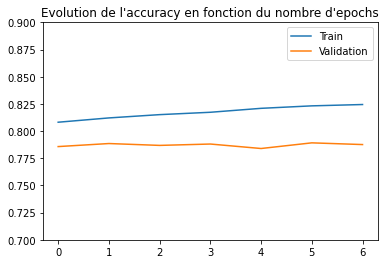

<IPython.core.display.Javascript object>

In [267]:
plt.figure()
plt.plot(history_simple_GRU_embed_glove_optim_best_model.history["accuracy"])
plt.plot(history_simple_GRU_embed_glove_optim_best_model.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.title("Evolution de l'accuracy en fonction du nombre d'epochs")
plt.ylim(0.7, 0.9)
plt.show()

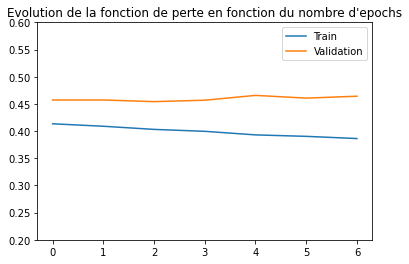

<IPython.core.display.Javascript object>

In [268]:
plt.figure()
plt.plot(history_simple_GRU_embed_glove_optim_best_model.history["loss"])
plt.plot(history_simple_GRU_embed_glove_optim_best_model.history["val_loss"])
plt.legend(["Train", "Validation"])
plt.title("Evolution de la fonction de perte en fonction du nombre d'epochs")
plt.ylim(0.2, 0.6)
plt.show()

##### Remarque : 
- L'ajout de couches Dropout a fonctionné : l'overfitting a diminué.

In [269]:
val_accuracy_per_epoch = history_simple_GRU_embed_glove_optim_best_model.history[
    "val_accuracy"
]

<IPython.core.display.Javascript object>

In [270]:
best_epoch = val_accuracy_per_epoch.index(max(val_accuracy_per_epoch)) + 1

<IPython.core.display.Javascript object>

In [271]:
best_epoch

6

<IPython.core.display.Javascript object>

### <span style='color:#019DA0'>Récapitulatif Meilleur modèle :</span>
- Architecture : simple GRU
- Plongement de mots : GloVe préentrainé sur des Tweets
- Hyper paramètres :
    - Dropout = 10% & 20%
    - Learning rate = 0.001
- Nombre d'epochs : 6
> **Avec ce meilleur modèle on obtient une accuracy de 0.789**

- Ce modèle de Deep Learning donne une même accuracy que celle du modèle de référence de type Machine Learning (0.79 vs 0.77)

> ### <span style='color:#6A00B3'>Comparaison avec les tweets non préprocessés et préprocessés 'léger'</span>
> #### <span style='color:#6A00B3'>Tweets non préprocessés :</span>

In [272]:
simple_GRU_embed_glove_optim_best_model_nopp = simple_GRU_embed_glove_optim_best_model

<IPython.core.display.Javascript object>

In [273]:
%%time
history_simple_GRU_embed_glove_optim_best_model_nopp = simple_GRU_embed_glove_optim_best_model_nopp.fit(X_train_sample_notpreprocessed_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=5, validation_data=(X_val_notpreprocessed_pad, y_val))

Epoch 1/5
313/313 [==============================] - 16s 50ms/step - loss: 0.3859 - accuracy: 0.8245 - val_loss: 0.4676 - val_accuracy: 0.7867
Epoch 2/5
313/313 [==============================] - 16s 51ms/step - loss: 0.3825 - accuracy: 0.8263 - val_loss: 0.4649 - val_accuracy: 0.7861
Epoch 3/5
313/313 [==============================] - 16s 50ms/step - loss: 0.3754 - accuracy: 0.8305 - val_loss: 0.4615 - val_accuracy: 0.7844
Epoch 4/5
313/313 [==============================] - 16s 51ms/step - loss: 0.3698 - accuracy: 0.8324 - val_loss: 0.4633 - val_accuracy: 0.7863
Epoch 5/5
313/313 [==============================] - 16s 50ms/step - loss: 0.3664 - accuracy: 0.8348 - val_loss: 0.4772 - val_accuracy: 0.7822
CPU times: user 5min 26s, sys: 9min 55s, total: 15min 22s
Wall time: 1min 18s


<IPython.core.display.Javascript object>

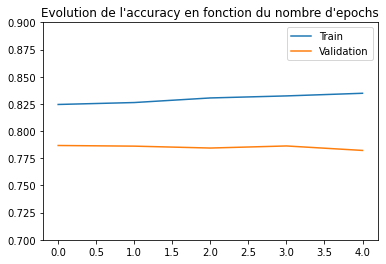

<IPython.core.display.Javascript object>

In [274]:
plt.figure()
plt.plot(history_simple_GRU_embed_glove_optim_best_model_nopp.history["accuracy"])
plt.plot(history_simple_GRU_embed_glove_optim_best_model_nopp.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.title("Evolution de l'accuracy en fonction du nombre d'epochs")
plt.ylim(0.7, 0.9)
plt.show()

### <span style='color:#019DA0'>Synthèse :</span>
- Les résultats sont moins bons : 
    - l'accuracy est un peu moins élevée (0.78 vs 0.79 pour le modèle avec Tweets préprocessés)
    - il y a légèrement plus d'overfitting avec le modèle Tweets non préprocessés

> #### <span style='color:#6A00B3'>Tweets préprocessés de façon 'légère' :

In [275]:
simple_GRU_embed_glove_optim_best_model_lightpp = (
    simple_GRU_embed_glove_optim_best_model
)

<IPython.core.display.Javascript object>

In [276]:
%%time
history_simple_GRU_embed_glove_optim_best_model_lightpp = simple_GRU_embed_glove_optim_best_model.fit(X_train_sample_lightpreprocessed_pad, y_train_sample, batch_size=BATCH_SIZE, epochs=5, validation_data=(X_val_lightpreprocessed_pad, y_val))

Epoch 1/5
313/313 [==============================] - 16s 52ms/step - loss: 0.3623 - accuracy: 0.8357 - val_loss: 0.4701 - val_accuracy: 0.7825
Epoch 2/5
313/313 [==============================] - 16s 52ms/step - loss: 0.3579 - accuracy: 0.8372 - val_loss: 0.4830 - val_accuracy: 0.7839
Epoch 3/5
313/313 [==============================] - 16s 50ms/step - loss: 0.3533 - accuracy: 0.8412 - val_loss: 0.4727 - val_accuracy: 0.7813
Epoch 4/5
313/313 [==============================] - 15s 49ms/step - loss: 0.3477 - accuracy: 0.8440 - val_loss: 0.4818 - val_accuracy: 0.7824
Epoch 5/5
313/313 [==============================] - 16s 50ms/step - loss: 0.3448 - accuracy: 0.8457 - val_loss: 0.5052 - val_accuracy: 0.7799
CPU times: user 5min 27s, sys: 10min 2s, total: 15min 30s
Wall time: 1min 19s


<IPython.core.display.Javascript object>

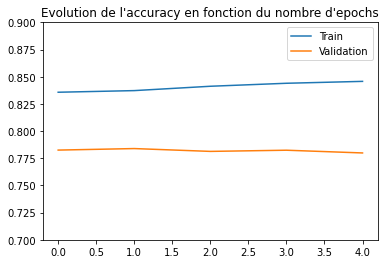

<IPython.core.display.Javascript object>

In [277]:
plt.figure()
plt.plot(history_simple_GRU_embed_glove_optim_best_model_lightpp.history["accuracy"])
plt.plot(
    history_simple_GRU_embed_glove_optim_best_model_lightpp.history["val_accuracy"]
)
plt.legend(["Train", "Validation"])
plt.title("Evolution de l'accuracy en fonction du nombre d'epochs")
plt.ylim(0.7, 0.9)
plt.show()

### <span style='color:#019DA0'>Synthèse :</span>
- Les résultats sont moins bons : 
    - l'accuracy est un peu moins élevée (0.78 vs 0.79 pour le modèle avec Tweets préprocessés de façon complète)
    - il y a légèrement plus d'overfitting avec le modèle Tweets préprocessés de façon légère

### <span style='color:#019DA0'>Conclusion pour le PreProcessing :</span>
- Le preprocessing des Tweets retenu permet d'améliorer le résultat

>## <span style='color:green' id="section_4_6" >4.6. Evaluation du meilleur modèle optimisé</span>

#### Entrainement du meilleur modèle optimisé sur tout le jeu d'entrainement

In [278]:
%%time
history_simple_GRU_embed_glove_optim_best_model = simple_GRU_embed_glove_optim_best_model.fit(X_train_pad, y_train, batch_size=BATCH_SIZE, epochs=best_epoch, callbacks=time_callback)

Epoch 1/6
644/644 [==============================] - 26s 40ms/step - loss: 0.4119 - accuracy: 0.8117
Epoch 2/6
644/644 [==============================] - 26s 41ms/step - loss: 0.4043 - accuracy: 0.8143
Epoch 3/6
644/644 [==============================] - 26s 41ms/step - loss: 0.3977 - accuracy: 0.8202
Epoch 4/6
644/644 [==============================] - 26s 40ms/step - loss: 0.3943 - accuracy: 0.8221
Epoch 5/6
644/644 [==============================] - 25s 39ms/step - loss: 0.3908 - accuracy: 0.8232
Epoch 6/6
644/644 [==============================] - 25s 38ms/step - loss: 0.3888 - accuracy: 0.8232
CPU times: user 10min 20s, sys: 19min 39s, total: 29min 59s
Wall time: 2min 33s


<IPython.core.display.Javascript object>

#### Evaluation du meilleur modèle optimisé sur le jeu de test

In [279]:
simple_GRU_embed_glove_optim_best_model_accuracy = (
    simple_GRU_embed_glove_optim_best_model.evaluate(X_test_pad, y_test)
)

644/644 [==============================] - 5s 7ms/step - loss: 0.4517 - accuracy: 0.7924


<IPython.core.display.Javascript object>

In [280]:
print(f"Accuracy score = {simple_GRU_embed_glove_optim_best_model_accuracy[1]:.3f}")

Accuracy score = 0.792


<IPython.core.display.Javascript object>

In [281]:
y_pred = simple_GRU_embed_glove_optim_best_model.predict(X_test_pad)

<IPython.core.display.Javascript object>

In [282]:
y_pred

array([[0.992444  ],
       [0.9651296 ],
       [0.93705446],
       ...,
       [0.9042294 ],
       [0.39714152],
       [0.4829851 ]], dtype=float32)

<IPython.core.display.Javascript object>

In [283]:
y_pred_classes = np.where(y_pred > 0.5, 1, 0)

<IPython.core.display.Javascript object>

In [284]:
y_pred_classes

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

<IPython.core.display.Javascript object>

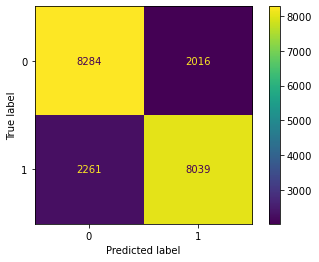

<IPython.core.display.Javascript object>

In [285]:
cm = confusion_matrix(y_test, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [286]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79     10300
           1       0.80      0.78      0.79     10300

    accuracy                           0.79     20600
   macro avg       0.79      0.79      0.79     20600
weighted avg       0.79      0.79      0.79     20600



<IPython.core.display.Javascript object>

### <span style='color:#019DA0'>Synthèse :</span>
- Sur tout le jeu d'entrainement on obtient une accuracy de **0.792**

>## <span style='color:green' id="section_4_7" >4.7. Sauvegarde du meilleur modèle (Format h5)</span>

In [287]:
simple_GRU_embed_glove_optim_best_model.save("airparadis_best_model.h5")

<IPython.core.display.Javascript object>

>## <span style='color:green' id="section_4_8" >4.8. Prédictions sur le jeu de données 'app' pour comparaison avec les autres approches</span>

In [288]:
simple_GRU_embed_glove_optim_best_model_app_accuracy = (
    simple_GRU_embed_glove_optim_best_model.evaluate(X_app_pad, y_app)
)

63/63 [==============================] - 1s 9ms/step - loss: 0.4399 - accuracy: 0.7960


<IPython.core.display.Javascript object>

#### Accuracy

In [289]:
print(f"Accuracy score = {simple_GRU_embed_glove_optim_best_model_app_accuracy[1]:.3f}")

Accuracy score = 0.796


<IPython.core.display.Javascript object>

#### Matrice de confusion

In [290]:
y_pred_app = simple_GRU_embed_glove_optim_best_model.predict(X_app_pad)

<IPython.core.display.Javascript object>

In [291]:
y_pred_app_classes = np.where(y_pred_app > 0.5, 1, 0)

<IPython.core.display.Javascript object>

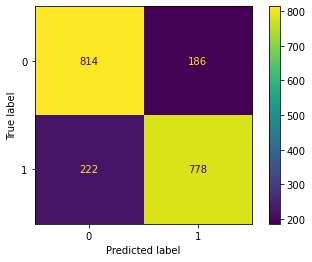

<IPython.core.display.Javascript object>

In [292]:
cm = confusion_matrix(y_app, y_pred_app_classes)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

#### Rapport de classification

In [293]:
print(classification_report(y_app, y_pred_app_classes))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1000
           1       0.81      0.78      0.79      1000

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



<IPython.core.display.Javascript object>

#### Conclusion :
- Sur tout le jeu le jeu de données 'app' pour comparaison avec les autres approches on obtient une accuracy de **0.796**

 # <span style='color:blue' id="section_5" >5. Prototype permettant de prédire le sentiment associé à un tweet</span>
- Ce prototype permet de prédire le sentiment associé à un tweet en utilisant le modèle 'local', c'est à dire le modèle se trouvant dans ce Notebook

>## <span style='color:green' id="section_5_1" >5.1. Fonction 'prototype' </span>
- prend en argument un Tweet
- renvoie la prédiction du sentiment et le score de probabilité associé au Tweet en entrée

In [294]:
def get_sentiment(tweet):
    tweet_clean = tweetpreprocessor.clean(tweet)
    tweet_clean_sequence = tokenizer.texts_to_sequences([tweet_clean])
    tweet_clean_pad = pad_sequences(
        tweet_clean_sequence,
        maxlen=MAX_WORD_LENGTH,
        padding=padding_type,
        truncating=trunc_type,
    )
    y_pred = simple_GRU_embed_glove_optim_best_model.predict(tweet_clean_pad)
    y_pred_classe = np.where(y_pred > 0.5, "positive", "negative")
    return f"Sentiment is : {y_pred_classe} - score = {y_pred}"

<IPython.core.display.Javascript object>

>## <span style='color:green' id="section_5_2" >5.2.  Test du modèle </span>
- Test sur 3 Tweets pour vérifier le bon fonctionnement du modèle. 

##### Tweet positif

In [295]:
get_sentiment("The service at AirParadis is good")

"Sentiment is : [['positive']] - score = [[0.9731026]]"

<IPython.core.display.Javascript object>

##### Tweet négatif

In [296]:
get_sentiment("The service at AirParadis is bad")

"Sentiment is : [['negative']] - score = [[0.04156199]]"

<IPython.core.display.Javascript object>

##### Tweet neutre

In [297]:
get_sentiment("The service at AirParadis is average")

"Sentiment is : [['negative']] - score = [[0.28564394]]"

<IPython.core.display.Javascript object>